In [1]:
import datetime
import argparse
import pandas as pd
import numpy as np

import scipy.io
import pickle
import numpy as np
import os
import h5py

import torch
from torch.utils.data import Dataset
from einops import rearrange
from tqdm import tqdm

In [2]:
# Implementing torch.dataset

def xform_day(day):
    arr = [0, 30, 61]
    w = 0 if day <= 30 else 1 if day <= 61 else 2
    mon = ['2020-11-', '2020-12-', '2021-01-'][w]
    date = mon + '{:02d}'.format(day - arr[w])
    return date


def get_suffixes(mode):
    suffixes = []
    if 'C' in mode or 'A' in mode:
        suffixes.append('train')
    if 'D' in mode or 'B' in mode:
        suffixes.append('test')
    return suffixes

def rename_cols(data):
    data.rename(
        columns={'dateTime': 'time', 'lat': 'latitude', 'long': 'longitude', 'pm2_5': 'PM25_Concentration',
                 'pm10': 'PM10_Concentration'}, inplace=True)



def torch1dgrid(num, bot=0, top=1):
    arr = torch.linspace(bot, top, steps=num)
    mesh = torch.stack([arr], dim=1)
    return mesh.squeeze(-1)

import torch
from torch.utils.data import Dataset
from einops import rearrange        
class Delhi(Dataset):
    def __init__(
        self, mode_t, mode_p, canada, train_days, 
        maxFolds = 5, target_fold = 0, temporal_scaling=1, spatiotemporal=1, data_dir='/pscratch/sd/d/dpark1/AirDelhi/delhi/processed', 
        seed=10, nTrainStartDay = 15, nTestStartDay = 75, nTotalDays = 91, train=True):
        
        self.mode_t = mode_t
        self.mode_p = mode_p
        self.train_days = train_days
        self.train = train
        self.maxFolds = maxFolds
        self.target_fold = target_fold
        self.temporal_scaling = temporal_scaling
        self.spatiotemporal = spatiotemporal
        self.data_dir = data_dir
        self.nTestStartDay = nTestStartDay
        self.nTrainStartDay = nTrainStartDay
        self.nTotalDays = nTotalDays
        
        np.random.seed(seed)        
        
        self.train_suffix = get_suffixes(mode_t)
                
        if spatiotemporal < 0 and mode_t == 'AB' and mode_p == 'CD':
            # Forecasting, single fold is enough
            maxFolds = 1
    
        self.folds = [i for i in range(maxFolds)]
        
        self.data, self.target = self.proc_custom(target_fold)
        
        
        
    def get_normalize_params(self, target):
        all_signal = []
        for a in target:
            all_signal += list(a[..., 0])
        self.mean, self.std = np.array(all_signal).mean(), np.array(all_signal).std()
    
    def get_spatial_norm_parameters(self, arr_of_days):
        """"minmax normalization"""
        latmin = 10e10
        latmax = -10e10
        longmin = 10e10
        longmax = -10e10
        for arr in arr_of_days:
            minned = arr.min(0)
            # print(minned[0])
            if minned[2] < latmin:
                latmin = minned[2]
            if minned[3] < longmin:
                longmin = minned[3]
                
            maxed = arr.max(0)
            # print(maxed)
            if maxed[2] > latmax:
                latmax = maxed[2]
            if maxed[3] > longmax:
                longmax = maxed[3]
        self.latmin, self.latmax, self.longmin, self.longmax =latmin, latmax, longmin, longmax
    
    def make_data_by_time(self, arr_of_days, t_in = 9, reverse=False, day = 0):
        seg_by_time = []
        uniq_times = np.unique(arr_of_days[..., 1])
        
        for t in uniq_times:
            idx_ = arr_of_days[..., 1] == t
            seg_by_time.append(arr_of_days[idx_])
        
        in_ = []
        out_ = []
        for i in range(len(seg_by_time) - t_in):
            temp_in = []
            for t_ in range(t_in):
                temp_in.append(seg_by_time[i + t_])
            
            # normalize time to relative scale by the last one of the encoder
            in_cand = np.copy(np.concatenate(temp_in, axis=0))
            out_cand = np.copy(seg_by_time[i + t_in])
            
            last_enc_t = in_cand[..., 1][-1]
            in_cand[..., 1] -= last_enc_t
            out_cand[..., 1] -= last_enc_t
            in_.append(in_cand)
            out_.append(out_cand)
            self.day_record.append(day)
            
            # reverse it
            if reverse:
                out_cand = np.copy(seg_by_time[i])
                temp_in = temp_in[1:]
                temp_in.append(seg_by_time[i + t_in])
                in_cand = np.copy(np.concatenate(temp_in, axis=0))
                last_enc_t = in_cand[..., 1][0]
                in_cand[..., 1] -= last_enc_t
                out_cand[..., 1] -= last_enc_t
                
                in_.append(in_cand)
                out_.append(out_cand)
                self.day_record.append(day)
        
        
        return in_, out_
    
    def proc_custom(self, fold):
        
        self.day_record = []
        
        train_data = {'input':[], 'target':[]}
        test_data = {'input':[], 'target':[]}
        
        for day in range(self.nTrainStartDay, self.nTestStartDay):
            date = []
            for i in range(self.train_days,-1,-1):
                date.append(xform_day(day-i))

            train_input,train_output,test_input,test_output = self.process_np(fold, date)
            train_in = np.concatenate([train_output[..., np.newaxis], train_input], axis=1) # 1 days
            train_out = np.concatenate([test_output[..., np.newaxis], test_input], axis=1) # 1 day
            
            seg_in, seg_out = self.make_data_by_time(train_in, day = day)
            
            train_data['input'] += seg_in
            train_data['target'] += seg_out            
        
        
        
        seg_in, seg_out = self.make_data_by_time(train_out)
        train_data['input'] += seg_in
        train_data['target'] += seg_out
            
        
        for day in range(self.nTestStartDay, self.nTotalDays+1):
            date = []
            for i in range(self.train_days,-1,-1):
                date.append(xform_day(day-i))

            train_input,train_output,test_input,test_output = self.process_np(fold, date)
            test_in = np.concatenate([train_output[..., np.newaxis], train_input], axis=1) # 1 days
            test_out = np.concatenate([test_output[..., np.newaxis], test_input], axis=1) # 1 day

            seg_in, seg_out = self.make_data_by_time(test_in, reverse = False)
            
            test_data['input'] += seg_in
            test_data['target'] += seg_out            
            
        seg_in, seg_out = self.make_data_by_time(test_out, reverse = False)
        test_data['input'] += seg_in
        test_data['target'] += seg_out

        self.get_normalize_params(train_data['target']) 
        self.get_spatial_norm_parameters(train_data['target'])
            
        if self.train:
            data = train_data['input']
            target = train_data['target']
            print(len(data), len(target))
            
        else:
            data = test_data['input']
            target = test_data['target']
            print(len(data), len(target))

        return data, target        
    
    

    def process_np(self, fold, date):
        tmStart = datetime.datetime.now()
        train_input,train_output,test_input,test_output = self.return_data_time(fold=fold, data=date, with_scaling=True)
        return train_input,train_output,test_input,test_output
    
    def return_data_time(self, fold, data, with_scaling):
        train_input = None
        if 'A' in self.mode_t or 'B' in self.mode_t:
            for idx,dt in enumerate(data[:-1]):
                for suffix in self.train_suffix:
                    input = pd.read_csv(self.data_dir+'/'+dt+'_f'+str(fold)+'_'+suffix+'.csv')
                    # if self.temporal_scaling:
                    #     input.dateTime += idx * 24 * 60
                    train_input = pd.concat((train_input, input))
                    
        if 'C' in self.mode_t:
            input = pd.read_csv(self.data_dir + '/' + data[-1] + '_f' + str(fold) + '_train.csv')
            # if self.temporal_scaling:
            #     input.dateTime += (len(data)-1) * 24 * 60
            train_input = pd.concat((train_input, input))

        test_input = pd.read_csv(self.data_dir+'/'+data[-1]+'_f'+str(fold)+'_test.csv')
        
        if 'C' in self.mode_p:
            input = pd.read_csv(self.data_dir + '/' + data[-1] + '_f' + str(fold) + '_train.csv')
            test_input = pd.concat((input, test_input))
            
        # if self.temporal_scaling:
        #     test_input.dateTime += (len(data)-1) * 24 * 60

        return self.return_data_0(train_input, test_input, with_scaling)

    
    def return_data_0(self, train_input, test_input, with_scaling):
        train_output = np.array(train_input['pm2_5'])
        train_input = train_input[['dateTime','lat','long']]
        test_output = np.array(test_input['pm2_5'])
        test_input = test_input[['dateTime','lat','long']]

        # if with_scaling:
        #     scaler = MinMaxScaler().fit(train_input)
        #     if self.temporal_scaling:
        #         data = scaler.transform(pd.concat((train_input, test_input)))
        #         test_input = data[len(train_input):]
        #         train_input = data[:len(train_input)]
        #     else:
        #         train_input = scaler.transform(train_input)
        #         test_input = scaler.transform(test_input)
        return train_input,train_output,test_input,test_output

    def set_target_fold(self, fold=0):
        self.fold = fold
        print('target fold set to {}'.format(self.fold))
        
    def normalize_z(self, arr):
        return (arr - self.mean) / self.std
    
    def normalize(self, data, min_, max_):
        return (data - min_) / (max_ - min_)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_, target_ = self.data[idx], self.target[idx]
        in_ = torch.from_numpy(input_.astype(np.float32))
        out_ = torch.from_numpy(target_.astype(np.float32))
        # print(in_)
        
        # Normalize pm2.5 values
        in_[..., 0] = self.normalize_z(in_[..., 0])
        out_[..., 0] = self.normalize_z(out_[..., 0])
        
        in_[..., 1] = in_[..., 1] / 1440
        out_[..., 1] = out_[..., 1] / 1440
        
        timegap = out_[..., 1:2][0] # get the gap between t+1 and t (ignoring t-1, and t-2)
        
        in_ = torch.cat([in_[..., 0:1], in_[..., 2:], in_[..., 1:2], ], dim=-1)
        out_ = torch.cat([out_[..., 0:1], out_[..., 2:], out_[..., 1:2], ], dim=-1)
        
        in_[..., 1] = self.normalize(in_[..., 1], self.latmin, self.latmax)
        out_[..., 1] = self.normalize(out_[..., 1], self.latmin, self.latmax)
        in_[..., 2] = self.normalize(in_[..., 2], self.longmin, self.longmax)
        out_[..., 2] = self.normalize(out_[..., 2], self.longmin, self.longmax)
        
        i = in_[..., 0:1]
        im = in_[..., 1:]
        o = out_[..., 0:1]
        om = out_[..., 1:]
        
        return i, o, im, om

In [ ]:
# ============================================================
# DDPM for AirDelhi (mentor setup)
#   - Data: mentor's Delhi dataloader (AB / CD, 9-step context)
#   - Task: 1-step spatiotemporal forecasting
#   - Conditioning: lat, lon, 9 past grids, 9 past masks  (total +20 channels)
#   - Target: next-slot PM2.5 grid (tanh(z-scored))
#   - Training loss: masked noise-prediction MSE (mask + tiny bg weight)
#   - Eval: masked RMSE on test split (raw µg/m³ and normalized)
# ============================================================
import os, math, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image, make_grid
from einops import rearrange
from tqdm import tqdm
import matplotlib.pyplot as plt


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# ---------------- paths / grid / training ----------------
DATA_DIR   = '/pscratch/sd/d/dpark1/AirDelhi/delhi/processed'  # <— your path
RESULT_DIR = './delhi_ddpm_ctx9_results_opt_nobg'
os.makedirs(RESULT_DIR, exist_ok=True)

H, W = 21, 20                      # 21×20 bins
BATCH_SIZE = 32
LR = 2e-4
TIME_STEPS = 1000                  # diffusion T
TOTAL_STEPS = 150_000
LOG_EVERY  = 200
EVAL_EVERY = 1000
SAVE_SAMPLES_EVERY = 1000
BG_WEIGHT = 0                   # tiny background weight so model learns background scale

# ============================================================
# 0) Your mentor's dataset must be defined/imported earlier
#     from your message it’s already in the notebook/session.
#     We’ll instantiate it below with AB/CD, T=1, 9-step context.
# ============================================================

# ============================================================
# 1) Helpers: splat irregular points -> grid (avg if multiple)
# ============================================================
def splat_grid(vals, coords_latlon, H=H, W=W):
    """
    vals:  (N,1)  (already z-scored OR tanh(z) per caller)
    coords_latlon: (N,2) in [0,1] = (lat, lon) from your dataloader
    returns: grid (H,W), mask (H,W) with averages per cell
    """
    grid = torch.zeros(H, W, dtype=torch.float32)
    cnt  = torch.zeros(H, W, dtype=torch.float32)
    if vals.numel() > 0:
        yy = (coords_latlon[:, 0].clamp(0,1) * (H-1)).round().long()
        xx = (coords_latlon[:, 1].clamp(0,1) * (W-1)).round().long()
        for y, x, v in zip(yy.tolist(), xx.tolist(), vals[:,0].tolist()):
            grid[y, x] += v
            cnt[y, x]  += 1.0
    mask = (cnt > 0).float()
    grid = torch.where(cnt > 0, grid / torch.clamp(cnt, min=1.0), grid)
    return grid, mask

# ============================================================
# 2) Wrapper: (i, o, im, om) → (x0, mask, cond)
#     cond = [lat_map, lon_map, past_grids(9), past_masks(9)]
#     x0   = target grid (tanh(z-scored))
# ============================================================
class DelhiToGridCtx9(Dataset):
    def __init__(self, base_dataset, squash_tanh=True):
        self.base = base_dataset            # your mentor's Delhi dataset
        self.squash = squash_tanh
        self.mean = float(self.base.mean)   # z-score params from base (train stats)
        self.std  = float(self.base.std)

        # prebuild lat/lon maps (constant across items)
        lat = torch.linspace(0, 1, H).unsqueeze(1).repeat(1, W)
        lon = torch.linspace(0, 1, W).unsqueeze(0).repeat(H, 1)
        self.lat_map = lat
        self.lon_map = lon

    def __len__(self): return len(self.base)

    def __getitem__(self, idx):
        # mentor dataloader returns:
        #   i  : (Ni,1)    encoder PM values (z-scored)
        #   o  : (No,1)    target  PM values (z-scored)
        #   im : (Ni,3)    [lat_norm, lon_norm, t_rel] for i
        #   om : (No,3)    [lat_norm, lon_norm, t_rel] for o (t_rel near 0)
        i, o, im, om = self.base[idx]

        # ---- build past 9 step grids/masks from encoder ----
        tvals = torch.unique(im[:,2])
        tvals, _ = torch.sort(tvals)        # oldest → newest
        assert len(tvals) == 9, f"Expected 9 encoder steps; got {len(tvals)}"

        past_grids, past_masks = [], []
        for t in tvals:
            sel = (im[:,2] == t)
            grid_t, mask_t = splat_grid(i[sel], im[sel, :2], H, W)    # i is z-scored
            if self.squash:
                grid_t = torch.tanh(grid_t)                           # tanh(z)
            past_grids.append(grid_t)
            past_masks.append(mask_t)
        past_grids = torch.stack(past_grids, 0)   # (9,H,W)
        past_masks = torch.stack(past_masks, 0)   # (9,H,W)

        # ---- target (next slot) grid/mask ----
        tgt_grid, tgt_mask = splat_grid(o, om[:, :2], H, W)           # o is z-scored
        x0 = torch.tanh(tgt_grid) if self.squash else tgt_grid        # (H,W)

        # ---- cond channels ----
        cond = torch.cat([
            self.lat_map.unsqueeze(0),          # (1,H,W)
            self.lon_map.unsqueeze(0),          # (1,H,W)
            past_grids,                         # (9,H,W)
            past_masks                          # (9,H,W)
        ], dim=0)                                # -> (20,H,W)

        return x0.unsqueeze(0), tgt_mask.unsqueeze(0), cond, self.mean, self.std

# ============================================================
# 3) UNet (no attention; rectangular-friendly)
# ============================================================
class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out=None, time_emb_dim=None, dropout=0.0, groups=32):
        super().__init__()
        dim_out = dim if dim_out is None else dim_out
        self.mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out)) if time_emb_dim else None
        self.norm1 = nn.GroupNorm(groups, dim);     self.conv1 = nn.Conv2d(dim, dim_out, 3, padding=1)
        self.norm2 = nn.GroupNorm(groups, dim_out); self.conv2 = nn.Conv2d(dim_out, dim_out, 3, padding=1)
        self.dropout = nn.Dropout(dropout) if dropout else nn.Identity()
        self.act = nn.SiLU()
        self.res = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()
    def forward(self, x, t_emb=None):
        h = self.conv1(self.act(self.norm1(x)))
        if self.mlp is not None and t_emb is not None:
            h = h + self.mlp(t_emb)[..., None, None]
        h = self.conv2(self.dropout(self.act(self.norm2(h))))
        return h + self.res(x)


class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, base_dim):
        super().__init__()
        self.out_dim = base_dim
    def forward(self, t):  # t: (B,)
        # classic transformer-style PE on scalar t
        half = self.out_dim // 2
        device = t.device
        freqs = torch.exp(torch.arange(half, device=device).float()
                          * -(math.log(10000.0) / max(1, half-1)))
        ang = t.float().unsqueeze(1) * freqs.unsqueeze(0)  # (B, half)
        emb = torch.cat([torch.sin(ang), torch.cos(ang)], dim=1)  # (B, 2*half)
        if emb.shape[1] < self.out_dim:
            emb = F.pad(emb, (0, self.out_dim - emb.shape[1]))
        return emb

class TimeMLP(nn.Module):
    def __init__(self, base_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, base_dim*4), nn.SiLU(),
            nn.Linear(base_dim*4, base_dim*4)
        )
    def forward(self, t):  # (B,)
        return self.net(t[:,None].float())

class UNet(nn.Module):
    def __init__(self, base_dim=128, dim_mults=(1,2,4),
                 in_channels=1+20, image_size=(H,W), dropout=0.0, groups=32):
        super().__init__()
        self.image_h, self.image_w = image_size
        self.time_dim = base_dim * 4

        # self.time_pe  = SinusoidalTimeEmbedding(base_dim)
        # self.time_mlp = nn.Sequential(
        #     nn.Linear(base_dim, self.time_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.time_dim, self.time_dim)
        # )
        self.time_mlp = TimeMLP(base_dim)
        self.init = nn.Conv2d(in_channels, base_dim, 3, padding=1)

        self.downs = nn.ModuleList()
        in_ch = base_dim
        skip_channels = []
        for li, m in enumerate(dim_mults):
            out_ch = base_dim * m
            rb1 = ResnetBlock(in_ch, out_ch, self.time_dim, dropout, groups); self.downs.append(rb1); in_ch = out_ch; skip_channels.append(in_ch)
            rb2 = ResnetBlock(in_ch, out_ch, self.time_dim, dropout, groups); self.downs.append(rb2); in_ch = out_ch; skip_channels.append(in_ch)
            if li != len(dim_mults) - 1:
                self.downs.append(nn.Conv2d(in_ch, in_ch, 3, stride=2, padding=1))

        self.mid1 = ResnetBlock(in_ch, in_ch, self.time_dim, dropout, groups)
        self.mid2 = ResnetBlock(in_ch, in_ch, self.time_dim, dropout, groups)

        self.ups, self.kinds = nn.ModuleList(), []
        sc = skip_channels.copy()
        for li, m in enumerate(reversed(dim_mults)):
            out_ch = base_dim * m
            for _ in range(2):
                skip_ch = sc.pop()
                self.ups.append(ResnetBlock(in_ch + skip_ch, out_ch, self.time_dim, dropout, groups)); self.kinds.append('res')
                in_ch = out_ch
            if li != len(dim_mults) - 1:
                self.ups.append(nn.Upsample(scale_factor=2, mode='nearest')); self.kinds.append('up')
                self.ups.append(nn.Conv2d(in_ch, in_ch, 3, padding=1));       self.kinds.append('conv')

        self.final = nn.Sequential(nn.GroupNorm(groups, in_ch), nn.SiLU(), nn.Conv2d(in_ch, 1, 3, padding=1))

    def forward(self, x_cat, t):
        # t_emb = self.time_mlp(self.time_pe(t))
        t_emb = self.time_mlp(t)
        skips, h = [], self.init(x_cat)
        for layer in self.downs:
            if isinstance(layer, ResnetBlock):
                h = layer(h, t_emb); skips.append(h)
            else:
                h = layer(h)
        h = self.mid1(h, t_emb); h = self.mid2(h, t_emb)
        for kind, layer in zip(self.kinds, self.ups):
            if kind == 'res':
                s = skips.pop()
                if s.shape[-2:] != h.shape[-2:]:
                    s = F.interpolate(s, size=h.shape[-2:], mode='nearest')
                h = layer(torch.cat([h, s], dim=1), t_emb)
            elif kind == 'up':
                h = layer(h)
            else:
                h = layer(h)
        if h.shape[-2:] != (self.image_h, self.image_w):
            h = F.interpolate(h, size=(self.image_h, self.image_w), mode='nearest')
        return self.final(h)

# ============================================================
# 4) Diffusion core — noise only target channel; cond is clean
# ============================================================
class GaussianDiffusion(nn.Module):
    def __init__(self, unet, image_size=(H,W), time_steps=TIME_STEPS, loss_type='l2'):
        super().__init__()
        self.unet = unet
        self.H, self.W = image_size
        self.T = time_steps
        self.loss_type = loss_type

        beta  = self.linear_beta_schedule(time_steps)
        alpha = 1. - beta
        abar  = torch.cumprod(alpha, dim=0)
        abar_prev = F.pad(abar[:-1], (1,0), value=1.)

        self.register_buffer('beta', beta)
        self.register_buffer('alpha', alpha)
        self.register_buffer('alpha_bar', abar)
        self.register_buffer('alpha_bar_prev', abar_prev)
        self.register_buffer('sqrt_alpha_bar', torch.sqrt(abar))
        self.register_buffer('sqrt_one_minus_alpha_bar', torch.sqrt(1 - abar))
        self.register_buffer('sqrt_recip_alpha_bar', torch.sqrt(1. / abar))
        self.register_buffer('sqrt_recip_alpha_bar_min_1', torch.sqrt(1. / abar - 1))
        self.register_buffer('sqrt_recip_alpha', torch.sqrt(1. / alpha))
        self.register_buffer('beta_over_sqrt_one_minus_alpha_bar', beta / torch.sqrt(1. - abar))

    def linear_beta_schedule(self, T):
        scale = 1000 / T
        return torch.linspace(scale*1e-4, scale*2e-2, T, dtype=torch.float32)

    def q_sample(self, x0, t, noise):
        return self.sqrt_alpha_bar[t][:,None,None,None] * x0 + \
               self.sqrt_one_minus_alpha_bar[t][:,None,None,None] * noise

    def forward(self, x0, mask, cond):
        """
        x0:   (B,1,H,W) in tanh(z) space
        mask: (B,1,H,W)  (1=observed bin in target; 0=unobserved)
        cond: (B,20,H,W) = [lat, lon, past_grids(9), past_masks(9)]
        """
        b = x0.size(0)
        t = torch.randint(0, self.T, (b,), device=x0.device).long()

        noise = torch.randn_like(x0)
        x_t   = self.q_sample(x0, t, noise)
        x_cat = torch.cat([x_t, cond], dim=1)  # noised target + clean cond

        pred = self.unet(x_cat, t)  # predict noise on target channel

        if self.loss_type == 'l1':
            raw = F.l1_loss(noise, pred, reduction='none')
        elif self.loss_type == 'l2':
            raw = F.mse_loss(noise, pred, reduction='none')
        else:
            raw = F.smooth_l1_loss(noise, pred, reduction='none')

        w = mask + BG_WEIGHT  # supervise observed bins + tiny everywhere
        return (raw * w).sum() / (w.sum() + 1e-8)

    @torch.inference_mode()
    def p_sample(self, xt, cond, t, clip=True):
        bt = torch.full((xt.shape[0],), t, device=xt.device, dtype=torch.long)
        x_cat = torch.cat([xt, cond], dim=1)
        pred_noise = self.unet(x_cat, bt)

        def bcast(x): return x.view(-1,1,1,1)
        if clip:
            x0 = bcast(self.sqrt_recip_alpha_bar[bt]) * xt - bcast(self.sqrt_recip_alpha_bar_min_1[bt]) * pred_noise
            x0 = x0.clamp(-1., 1.)
            c1 = self.beta[bt] * torch.sqrt(self.alpha_bar_prev[bt]) / (1. - self.alpha_bar[bt])
            c2 = torch.sqrt(self.alpha[bt]) * (1. - self.alpha_bar_prev[bt]) / (1. - self.alpha[bt])
            mean = bcast(c1) * x0 + bcast(c2) * xt
        else:
            mean = bcast(self.sqrt_recip_alpha[bt]) * (xt - bcast(self.beta_over_sqrt_one_minus_alpha_bar[bt]) * pred_noise)
        var = self.beta[bt] * ((1. - self.alpha_bar_prev[bt]) / (1. - self.alpha_bar[bt]))
        noise = torch.randn_like(xt) if t > 0 else 0.
        return mean + torch.sqrt(bcast(var)) * noise

    @torch.inference_mode()
    def sample(self, cond, clip=False):  # clip=False often gives crisper fields
        b = cond.size(0)
        x = torch.randn((b,1,self.H,self.W), device=cond.device)
        for t in reversed(range(self.T)):
            x = self.p_sample(x, cond, t, clip=clip)
        return x.clamp(-1, 1)

# ============================================================
# 5) Instantiate mentor dataset (AB/CD) + our ctx9 wrapper
# ============================================================
mode_t = 'AB'
mode_p = 'CD'
canada = 0
train_days = 1
Tflag = 1   # (the repo’s temporal scaling switch is effectively a no-op here)

base_train = Delhi(mode_t, mode_p, canada=canada, train_days=train_days, temporal_scaling=Tflag,
                   maxFolds=5, target_fold=0, spatiotemporal=1, train=True,  data_dir=DATA_DIR)
base_test  = Delhi(mode_t, mode_p, canada=canada, train_days=train_days, temporal_scaling=Tflag,
                   maxFolds=5, target_fold=0, spatiotemporal=1, train=False, data_dir=DATA_DIR)

train_set = DelhiToGridCtx9(base_train, squash_tanh=True)
test_set  = DelhiToGridCtx9(base_test,  squash_tanh=True)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=2, pin_memory=True)

x0_ex, m_ex, cond_ex, mu_ex, std_ex = train_set[0]
print("Example shapes:", x0_ex.shape, m_ex.shape, cond_ex.shape, "| mean/std:", mu_ex, std_ex)

# ============================================================
# 6) Build model + diffusion + optimizer
# ============================================================
IN_CHANNELS = 1 + 2 + 9 + 9   # target(noised) + lat/lon + 9 past grids + 9 past masks = 21
unet = UNet(base_dim=128, dim_mults=(1,2,4), in_channels=IN_CHANNELS, image_size=(H,W)).to(DEVICE)
diffusion = GaussianDiffusion(unet, image_size=(H,W), time_steps=TIME_STEPS, loss_type='l2').to(DEVICE)

# ---- CosineAnnealingWarmupRestarts setup ----
from torch.optim import AdamW
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

max_lr = 4e-4
min_lr = 8e-6
TOTAL_ITERS = TOTAL_STEPS          # keep these tied
warmup_steps = max(1, int(0.1 * TOTAL_ITERS))
weight_decay = 1e-4

opt = AdamW(diffusion.parameters(), lr=max_lr, betas=(0.9, 0.999), weight_decay=weight_decay)

sched = CosineAnnealingWarmupRestarts(
    optimizer=opt,
    first_cycle_steps=TOTAL_ITERS,  # single full-length cosine cycle
    max_lr=max_lr,
    min_lr=min_lr,
    warmup_steps=warmup_steps,
    gamma=1.0                       # no decay across cycles since we use one cycle
)

# ============================================================
# 7) Utilities: invert tanh->raw and metrics
# ============================================================
def inv_tanh_to_raw(x_tanh, mean, std):
    z = torch.atanh(x_tanh.clamp(-0.999, 0.999))
    return z * std + mean

@torch.no_grad()
def eval_rmse(diffusion, loader):
    mse_sum_raw = 0.0; w_sum = 0.0
    mse_sum_norm = 0.0
    for x0_te, m_te, c_te, mu_te, std_te in loader:
        x0_te  = x0_te.to(DEVICE)   # tanh(z)
        m_te   = m_te.to(DEVICE)
        c_te   = c_te.to(DEVICE)
        mu_te  = mu_te.to(DEVICE)[:,None,None,None]
        std_te = std_te.to(DEVICE)[:,None,None,None]

        xhat = diffusion.sample(c_te, clip=False)             # tanh(z)
        # raw µg/m³
        raw_hat = inv_tanh_to_raw(xhat,  mu_te, std_te)
        raw_gt  = inv_tanh_to_raw(x0_te, mu_te, std_te)

        mse_sum_raw  += ((raw_hat - raw_gt)**2 * m_te).sum().item()
        w_sum        += m_te.sum().item()
        # normalized (z) space RMSE (mask)
        zhat = torch.atanh(xhat.clamp(-0.999, 0.999))
        zgt  = torch.atanh(x0_te.clamp(-0.999, 0.999))
        mse_sum_norm += ((zhat - zgt)**2 * m_te).sum().item()

    rmse_raw  = math.sqrt(mse_sum_raw / max(w_sum, 1e-8))
    rmse_norm = math.sqrt(mse_sum_norm / max(w_sum, 1e-8))
    return rmse_raw, rmse_norm, int(w_sum)


import math

@torch.no_grad()
def _crps_from_ensemble(y_flat, samples_flat):
    """
    y_flat:        (N,) ground-truth vector (masked entries only later)
    samples_flat:  (K,N) ensemble samples
    returns:       (N,) CRPS per entry
    """
    K = samples_flat.shape[0]
    # term1 = E|X - y|  ≈ (1/K) Σ_i |x_i - y|
    term1 = (samples_flat - y_flat.unsqueeze(0)).abs().mean(dim=0)  # (N,)
    # term2 = 0.5 * E|X - X'| ≈ 0.5 * (1/K^2) Σ_ij |x_i - x_j|
    diffs = samples_flat.unsqueeze(0) - samples_flat.unsqueeze(1)   # (K,K,N)
    term2 = 0.5 * diffs.abs().mean(dim=(0,1))                      # (N,)
    return term1 - term2                                            # (N,)

@torch.no_grad()
def eval_crps_and_points(diffusion, loader, K=10, clip=False):
    """
    Returns masked dataset-averaged:
      CRPS_raw, CRPS_norm, MAE_raw, RMSE_raw, MAE_norm, RMSE_norm, n_obs_bins
    """
    crps_raw_sum = 0.0
    crps_norm_sum = 0.0
    mae_raw_sum = 0.0
    rmse_raw_sum = 0.0
    mae_norm_sum = 0.0
    rmse_norm_sum = 0.0
    w_sum = 0.0

    for x0_te, m_te, c_te, mu_te, std_te in loader:
        x0_te  = x0_te.to(DEVICE)          # (B,1,H,W), tanh(z)
        m_te   = m_te.to(DEVICE)           # (B,1,H,W) mask
        c_te   = c_te.to(DEVICE)           # (B,20,H,W)
        mu_te  = mu_te.to(DEVICE)[:,None,None,None]
        std_te = std_te.to(DEVICE)[:,None,None,None]

        B, _, H, W = x0_te.shape
        N = B*H*W
        mask_flat = m_te.view(N).bool()

        # K samples
        samples = []
        for _ in range(K):
            xhat = diffusion.sample(c_te, clip=clip)             # (B,1,H,W) tanh(z)
            samples.append(xhat)
        S = torch.stack(samples, dim=0)                          # (K,B,1,H,W)

        # normalized (z)
        z_gt  = torch.atanh(x0_te.clamp(-0.999, 0.999))          # (B,1,H,W)
        z_smp = torch.atanh(S.clamp(-0.999, 0.999))              # (K,B,1,H,W)

        # raw μg/m³
        raw_gt  = z_gt * std_te + mu_te                          # (B,1,H,W)
        raw_smp = z_smp * std_te + mu_te                         # (K,B,1,H,W)

        # flatten
        z_gt_f   = z_gt.view(N)
        raw_gt_f = raw_gt.view(N)
        z_smp_f  = z_smp.view(K, N)
        raw_smp_f= raw_smp.view(K, N)

        # CRPS (masked mean)
        crps_norm = _crps_from_ensemble(z_gt_f,   z_smp_f)[mask_flat].mean()
        crps_raw  = _crps_from_ensemble(raw_gt_f, raw_smp_f)[mask_flat].mean()
        crps_norm_sum += crps_norm.item() * mask_flat.sum().item()
        crps_raw_sum  += crps_raw.item()  * mask_flat.sum().item()

        # point forecast = ensemble mean
        z_mean   = z_smp.mean(dim=0).view(N)
        raw_mean = raw_smp.mean(dim=0).view(N)

        # MAE/RMSE (masked)
        mae_norm_sum  += (z_mean - z_gt_f).abs()[mask_flat].sum().item()
        rmse_norm_sum += ((z_mean - z_gt_f)**2)[mask_flat].sum().item()
        mae_raw_sum   += (raw_mean - raw_gt_f).abs()[mask_flat].sum().item()
        rmse_raw_sum  += ((raw_mean - raw_gt_f)**2)[mask_flat].sum().item()

        w_sum += mask_flat.sum().item()

    CRPS_raw  = crps_raw_sum  / max(w_sum, 1e-8)
    CRPS_norm = crps_norm_sum / max(w_sum, 1e-8)
    MAE_raw   = mae_raw_sum   / max(w_sum, 1e-8)
    MAE_norm  = mae_norm_sum  / max(w_sum, 1e-8)
    RMSE_raw  = math.sqrt(rmse_raw_sum  / max(w_sum, 1e-8))
    RMSE_norm = math.sqrt(rmse_norm_sum / max(w_sum, 1e-8))

    return dict(
        CRPS_raw=CRPS_raw, CRPS_norm=CRPS_norm,
        MAE_raw=MAE_raw, RMSE_raw=RMSE_raw,
        MAE_norm=MAE_norm, RMSE_norm=RMSE_norm,
        K=K, n_obs_bins=int(w_sum),
    )



# ============================================================
# 8) Training loop with periodic eval + checkpoint
# ============================================================
best_rmse = float('inf')
ckpt = os.path.join(RESULT_DIR, 'best_ctx9.pt')

pbar = tqdm(range(TOTAL_STEPS), desc="Train(ctx9)")
run_loss = 0.0
it = iter(train_loader)

for step in pbar:
    try:
        x0, msk, cond, mu, std = next(it)
    except StopIteration:
        it = iter(train_loader)
        x0, msk, cond, mu, std = next(it)

    x0   = x0.to(DEVICE, non_blocking=True)
    msk  = msk.to(DEVICE, non_blocking=True)
    cond = cond.to(DEVICE, non_blocking=True)

    opt.zero_grad(set_to_none=True)
    loss = diffusion(x0, msk, cond)
    loss.backward()
    nn.utils.clip_grad_norm_(diffusion.parameters(), 1.0)
    opt.step()
    sched.step()

    run_loss += loss.item()
    if (step+1) % LOG_EVERY == 0:
        avg = run_loss / LOG_EVERY
        run_loss = 0.0
        # grab LR robustly
        curr_lr = opt.param_groups[0]["lr"]
        pbar.set_postfix(loss=f"{avg:.4f}", lr=f"{curr_lr:.2e}")


    if (step+1) % EVAL_EVERY == 0:
        diffusion.eval()
        with torch.inference_mode():
            rmse_raw, rmse_norm, nobs = eval_rmse(diffusion, test_loader)
            # m = eval_crps_and_points(diffusion, test_loader, K=10, clip=False)  # <-- CRPS (and friends)
        print(f"\n[Step {step+1}] Test RMSE_raw={rmse_raw:.3f} µg/m³ | RMSE_norm={rmse_norm:.3f} (over {nobs} bins)")

        
        # print(f"\n[Step {step+1}] Test RMSE_raw={rmse_raw:.3f} µg/m³ | RMSE_norm={rmse_norm:.3f} "
        #       f"(over {nobs} bins) | CRPS_raw={m['CRPS_raw']:.3f} µg/m³ (K={m['K']})")
        if rmse_raw < best_rmse:
            best_rmse = rmse_raw
            torch.save({'unet': unet.state_dict(),
                        'diff': diffusion.state_dict(),
                        'H': H, 'W': W}, ckpt)
            print(f"  >> Saved best checkpoint @ {ckpt} (RMSE_raw={best_rmse:.3f})")
        diffusion.train()

    if (step+1) % SAVE_SAMPLES_EVERY == 0:
        diffusion.eval()
        with torch.inference_mode():
            # grab a test batch, sample, and save plain grids (tanh -> [0,1] for viewing)
            xb, mb, cb, mub, stdb = next(iter(test_loader))
            xhat = diffusion.sample(cb.to(DEVICE)).cpu()
            vis = (xhat + 1.0) * 0.5
            save_image(vis, os.path.join(RESULT_DIR, f"samples_step{step+1}.png"), nrow=4)
        diffusion.train()

print("Done. Best Test RMSE_raw:", best_rmse)

# ============================================================
# 9) Inference + overlay: GT vs Pred (only observed bins)
# ============================================================
def overlay_panel(test_loader, model, save_path=os.path.join(RESULT_DIR, 'ctx9_overlay.png'),
                  back_img='./airdelhi_background.png'):
    try:
        back = plt.imread(back_img)
    except:
        back = None

    import matplotlib.colors as colors
    from matplotlib.colors import LinearSegmentedColormap
    cmap0 = LinearSegmentedColormap.from_list('', ['white', 'orange', 'red'])

    with torch.inference_mode():
        xb, mb, cb, mub, stdb = next(iter(test_loader))
        xhat = model.sample(cb.to(DEVICE), clip=False).cpu()  # tanh(z)
        raw_hat = inv_tanh_to_raw(xhat, mub[:,None,None,None], stdb[:,None,None,None]).squeeze(1)
        raw_gt  = inv_tanh_to_raw(xb,   mub[:,None,None,None], stdb[:,None,None,None]).squeeze(1)
        mb      = mb.squeeze(1)

    vmax = float(mub.mean() + 3*stdb.mean())
    lon_edges = np.linspace(0,1,W+1); lat_edges = np.linspace(0,1,H+1)

    B = min(8, raw_hat.size(0))
    fig, axes = plt.subplots(2, B, figsize=(3.4*B, 6.8))
    for i in range(B):
        for row, arr in enumerate([raw_gt[i].numpy(), raw_hat[i].numpy()]):
            ax = axes[row, i]
            if back is not None: ax.imshow(back, extent=[0,1,0,1], alpha=0.6)
            arr_plot = arr.copy()
            arr_plot[mb[i].numpy() == 0] = np.nan  # show only observed bins
            pm = ax.pcolormesh(lon_edges, lat_edges, arr_plot, cmap=cmap0,
                               norm=colors.Normalize(vmin=0, vmax=vmax))
            # draw grid
            for y in lat_edges: ax.plot([0,1],[y,y], c='k', lw=0.1)
            for x in lon_edges: ax.plot([x,x],[0,1], c='k', lw=0.1)
            ax.set_axis_off()
        axes[0, i].set_title("GT (obs bins)", fontsize=11)
        axes[1, i].set_title("Pred (obs bins)", fontsize=11)

    cbar = fig.colorbar(pm, ax=axes.ravel().tolist(), fraction=0.03, pad=0.02)
    cbar.ax.tick_params(labelsize=10)
    plt.tight_layout(); plt.savefig(save_path, dpi=140, bbox_inches='tight'); plt.close(fig)
    print("Saved overlays to:", save_path)

# ---- Run an overlay on current (or best-loaded) model ----
overlay_panel(test_loader, diffusion)

# ============================================================
# 10) Load best checkpoint & run full test-day eval again
# ============================================================
def load_and_eval(ckpt_path, test_loader):
    ck = torch.load(ckpt_path, map_location=DEVICE)
    unet = UNet(base_dim=128, dim_mults=(1,2,4), in_channels=IN_CHANNELS, image_size=(H,W)).to(DEVICE)
    unet.load_state_dict(ck['unet'])
    diff = GaussianDiffusion(unet, image_size=(H,W), time_steps=TIME_STEPS, loss_type='l2').to(DEVICE)
    diff.load_state_dict(ck['diff'])
    diff.eval()

    rmse_raw, rmse_norm, nobs = eval_rmse(diff, test_loader)
    print(f"[BEST] Test RMSE_raw={rmse_raw:.3f} µg/m³ | RMSE_norm={rmse_norm:.3f} (over {nobs} bins)")
    overlay_panel(test_loader, diff, save_path=os.path.join(RESULT_DIR, 'ctx9_overlay_best.png'))
    return diff

# Example (after training): 
diff_best = load_and_eval(ckpt,test_loader)


1574 1574
468 468
Example shapes: torch.Size([1, 21, 20]) torch.Size([1, 21, 20]) torch.Size([20, 21, 20]) | mean/std: 171.93007238439924 87.80334021676569


Train(ctx9):   1%|          | 999/150000 [02:42<6:31:06,  6.35it/s, loss=0.2223, lr=3.41e-05] 


[Step 1000] Test RMSE_raw=335.205 µg/m³ | RMSE_norm=3.818 (over 17449 bins)
  >> Saved best checkpoint @ ./delhi_ddpm_ctx9_results_opt_nobg/best_ctx9.pt (RMSE_raw=335.205)


Train(ctx9):   1%|▏         | 1999/150000 [06:56<6:18:19,  6.52it/s, loss=0.1386, lr=6.03e-05]  


[Step 2000] Test RMSE_raw=311.855 µg/m³ | RMSE_norm=3.552 (over 17449 bins)
  >> Saved best checkpoint @ ./delhi_ddpm_ctx9_results_opt_nobg/best_ctx9.pt (RMSE_raw=311.855)


Train(ctx9):   2%|▏         | 2998/150000 [11:10<6:54:16,  5.91it/s, loss=0.1070, lr=8.64e-05]  


[Step 3000] Test RMSE_raw=340.562 µg/m³ | RMSE_norm=3.879 (over 17449 bins)


Train(ctx9):   3%|▎         | 3998/150000 [15:23<6:41:41,  6.06it/s, loss=0.0947, lr=1.13e-04]  


[Step 4000] Test RMSE_raw=272.648 µg/m³ | RMSE_norm=3.105 (over 17449 bins)
  >> Saved best checkpoint @ ./delhi_ddpm_ctx9_results_opt_nobg/best_ctx9.pt (RMSE_raw=272.648)


Train(ctx9):   3%|▎         | 4999/150000 [19:35<8:27:21,  4.76it/s, loss=0.0828, lr=1.39e-04]  


[Step 5000] Test RMSE_raw=189.981 µg/m³ | RMSE_norm=2.164 (over 17449 bins)
  >> Saved best checkpoint @ ./delhi_ddpm_ctx9_results_opt_nobg/best_ctx9.pt (RMSE_raw=189.981)


Train(ctx9):   4%|▍         | 5999/150000 [23:49<6:11:55,  6.45it/s, loss=0.0782, lr=1.65e-04]  


[Step 6000] Test RMSE_raw=199.212 µg/m³ | RMSE_norm=2.269 (over 17449 bins)


Train(ctx9):   5%|▍         | 6999/150000 [28:01<6:12:22,  6.40it/s, loss=0.0768, lr=1.91e-04]  


[Step 7000] Test RMSE_raw=162.092 µg/m³ | RMSE_norm=1.846 (over 17449 bins)
  >> Saved best checkpoint @ ./delhi_ddpm_ctx9_results_opt_nobg/best_ctx9.pt (RMSE_raw=162.092)


Train(ctx9):   5%|▌         | 7998/150000 [32:14<6:21:14,  6.21it/s, loss=0.0743, lr=2.17e-04]  


[Step 8000] Test RMSE_raw=159.143 µg/m³ | RMSE_norm=1.812 (over 17449 bins)
  >> Saved best checkpoint @ ./delhi_ddpm_ctx9_results_opt_nobg/best_ctx9.pt (RMSE_raw=159.143)


Train(ctx9):   6%|▌         | 8998/150000 [36:27<6:10:01,  6.35it/s, loss=0.0709, lr=2.43e-04]  


[Step 9000] Test RMSE_raw=143.464 µg/m³ | RMSE_norm=1.634 (over 17449 bins)
  >> Saved best checkpoint @ ./delhi_ddpm_ctx9_results_opt_nobg/best_ctx9.pt (RMSE_raw=143.464)


Train(ctx9):   7%|▋         | 9999/150000 [40:40<7:18:52,  5.32it/s, loss=0.0711, lr=2.69e-04]  


[Step 10000] Test RMSE_raw=154.863 µg/m³ | RMSE_norm=1.764 (over 17449 bins)


Train(ctx9):   7%|▋         | 10999/150000 [44:53<6:06:03,  6.33it/s, loss=0.0673, lr=2.95e-04]  


[Step 11000] Test RMSE_raw=137.339 µg/m³ | RMSE_norm=1.564 (over 17449 bins)
  >> Saved best checkpoint @ ./delhi_ddpm_ctx9_results_opt_nobg/best_ctx9.pt (RMSE_raw=137.339)


Train(ctx9):   8%|▊         | 11999/150000 [49:07<6:00:20,  6.38it/s, loss=0.0618, lr=3.22e-04]  


[Step 12000] Test RMSE_raw=113.269 µg/m³ | RMSE_norm=1.290 (over 17449 bins)
  >> Saved best checkpoint @ ./delhi_ddpm_ctx9_results_opt_nobg/best_ctx9.pt (RMSE_raw=113.269)


Train(ctx9):   9%|▊         | 12998/150000 [53:21<5:59:30,  6.35it/s, loss=0.0619, lr=3.48e-04]  


[Step 13000] Test RMSE_raw=122.328 µg/m³ | RMSE_norm=1.393 (over 17449 bins)


Train(ctx9):   9%|▉         | 13998/150000 [57:34<5:43:54,  6.59it/s, loss=0.0561, lr=3.74e-04]  


[Step 14000] Test RMSE_raw=138.093 µg/m³ | RMSE_norm=1.573 (over 17449 bins)


Train(ctx9):  10%|▉         | 14999/150000 [1:01:51<6:49:39,  5.49it/s, loss=0.0553, lr=4.00e-04]


[Step 15000] Test RMSE_raw=97.177 µg/m³ | RMSE_norm=1.107 (over 17449 bins)
  >> Saved best checkpoint @ ./delhi_ddpm_ctx9_results_opt_nobg/best_ctx9.pt (RMSE_raw=97.177)


Train(ctx9):  11%|█         | 15999/150000 [1:06:09<5:50:51,  6.37it/s, loss=0.0522, lr=4.00e-04]  


[Step 16000] Test RMSE_raw=135.037 µg/m³ | RMSE_norm=1.538 (over 17449 bins)


Train(ctx9):  11%|█▏        | 16999/150000 [1:10:23<5:38:15,  6.55it/s, loss=0.0533, lr=4.00e-04]  


[Step 17000] Test RMSE_raw=118.870 µg/m³ | RMSE_norm=1.354 (over 17449 bins)


Train(ctx9):  12%|█▏        | 17998/150000 [1:14:38<5:53:40,  6.22it/s, loss=0.0484, lr=4.00e-04]  


[Step 18000] Test RMSE_raw=116.413 µg/m³ | RMSE_norm=1.326 (over 17449 bins)


Train(ctx9):  13%|█▎        | 18998/150000 [1:18:52<5:36:40,  6.49it/s, loss=0.0411, lr=3.99e-04]  


[Step 19000] Test RMSE_raw=118.570 µg/m³ | RMSE_norm=1.350 (over 17449 bins)


Train(ctx9):  13%|█▎        | 19999/150000 [1:23:06<6:12:13,  5.82it/s, loss=0.0390, lr=3.99e-04]  


[Step 20000] Test RMSE_raw=106.323 µg/m³ | RMSE_norm=1.211 (over 17449 bins)


Train(ctx9):  14%|█▍        | 20999/150000 [1:27:20<5:31:14,  6.49it/s, loss=0.0396, lr=3.98e-04]  


[Step 21000] Test RMSE_raw=106.360 µg/m³ | RMSE_norm=1.211 (over 17449 bins)


Train(ctx9):  15%|█▍        | 21999/150000 [1:31:32<5:25:12,  6.56it/s, loss=0.0345, lr=3.97e-04]  


[Step 22000] Test RMSE_raw=109.293 µg/m³ | RMSE_norm=1.245 (over 17449 bins)


Train(ctx9):  15%|█▌        | 22998/150000 [1:35:46<5:40:03,  6.22it/s, loss=0.0399, lr=3.97e-04]  


[Step 23000] Test RMSE_raw=112.068 µg/m³ | RMSE_norm=1.276 (over 17449 bins)


Train(ctx9):  16%|█▌        | 23998/150000 [1:39:59<5:26:10,  6.44it/s, loss=0.0368, lr=3.96e-04]  


[Step 24000] Test RMSE_raw=112.003 µg/m³ | RMSE_norm=1.276 (over 17449 bins)


Train(ctx9):  17%|█▋        | 24999/150000 [1:44:12<5:44:49,  6.04it/s, loss=0.0352, lr=3.95e-04]  


[Step 25000] Test RMSE_raw=115.378 µg/m³ | RMSE_norm=1.314 (over 17449 bins)


Train(ctx9):  17%|█▋        | 25999/150000 [1:48:25<5:26:25,  6.33it/s, loss=0.0345, lr=3.94e-04]  


[Step 26000] Test RMSE_raw=100.393 µg/m³ | RMSE_norm=1.143 (over 17449 bins)


Train(ctx9):  18%|█▊        | 26999/150000 [1:52:38<4:59:44,  6.84it/s, loss=0.0321, lr=3.92e-04]  


[Step 27000] Test RMSE_raw=111.290 µg/m³ | RMSE_norm=1.267 (over 17449 bins)


Train(ctx9):  19%|█▊        | 27998/150000 [1:56:52<5:09:54,  6.56it/s, loss=0.0316, lr=3.91e-04]  


[Step 28000] Test RMSE_raw=114.064 µg/m³ | RMSE_norm=1.299 (over 17449 bins)


Train(ctx9):  19%|█▉        | 28998/150000 [2:01:04<5:13:29,  6.43it/s, loss=0.0315, lr=3.90e-04]  


[Step 29000] Test RMSE_raw=105.234 µg/m³ | RMSE_norm=1.199 (over 17449 bins)


Train(ctx9):  20%|█▉        | 29999/150000 [2:05:17<5:18:30,  6.28it/s, loss=0.0295, lr=3.88e-04]  


[Step 30000] Test RMSE_raw=105.962 µg/m³ | RMSE_norm=1.207 (over 17449 bins)


Train(ctx9):  21%|██        | 30999/150000 [2:09:30<5:08:07,  6.44it/s, loss=0.0316, lr=3.87e-04]  


[Step 31000] Test RMSE_raw=98.954 µg/m³ | RMSE_norm=1.127 (over 17449 bins)


Train(ctx9):  21%|██▏       | 31998/150000 [2:13:44<7:08:18,  4.59it/s, loss=0.0306, lr=3.85e-04]  


[Step 32000] Test RMSE_raw=89.806 µg/m³ | RMSE_norm=1.023 (over 17449 bins)
  >> Saved best checkpoint @ ./delhi_ddpm_ctx9_results_opt_nobg/best_ctx9.pt (RMSE_raw=89.806)


Train(ctx9):  22%|██▏       | 32998/150000 [2:17:58<5:29:50,  5.91it/s, loss=0.0279, lr=3.83e-04]  


[Step 33000] Test RMSE_raw=101.093 µg/m³ | RMSE_norm=1.151 (over 17449 bins)


Train(ctx9):  23%|██▎       | 33998/150000 [2:22:11<5:00:04,  6.44it/s, loss=0.0259, lr=3.81e-04]  


[Step 34000] Test RMSE_raw=105.629 µg/m³ | RMSE_norm=1.203 (over 17449 bins)


Train(ctx9):  23%|██▎       | 34999/150000 [2:26:25<5:09:07,  6.20it/s, loss=0.0249, lr=3.79e-04]  


[Step 35000] Test RMSE_raw=106.571 µg/m³ | RMSE_norm=1.214 (over 17449 bins)


Train(ctx9):  24%|██▍       | 35999/150000 [2:30:38<4:58:06,  6.37it/s, loss=0.0246, lr=3.77e-04]  


[Step 36000] Test RMSE_raw=102.288 µg/m³ | RMSE_norm=1.165 (over 17449 bins)


Train(ctx9):  25%|██▍       | 36998/150000 [2:34:53<6:30:09,  4.83it/s, loss=0.0231, lr=3.75e-04]  


[Step 37000] Test RMSE_raw=103.936 µg/m³ | RMSE_norm=1.184 (over 17449 bins)


Train(ctx9):  25%|██▌       | 37998/150000 [2:39:06<4:55:06,  6.33it/s, loss=0.0237, lr=3.73e-04]  


[Step 38000] Test RMSE_raw=104.792 µg/m³ | RMSE_norm=1.193 (over 17449 bins)


Train(ctx9):  26%|██▌       | 38998/150000 [2:43:19<4:55:26,  6.26it/s, loss=0.0267, lr=3.70e-04]  


[Step 39000] Test RMSE_raw=98.780 µg/m³ | RMSE_norm=1.125 (over 17449 bins)


Train(ctx9):  27%|██▋       | 39999/150000 [2:47:33<4:51:09,  6.30it/s, loss=0.0270, lr=3.68e-04]  


[Step 40000] Test RMSE_raw=100.910 µg/m³ | RMSE_norm=1.149 (over 17449 bins)


Train(ctx9):  27%|██▋       | 40999/150000 [2:51:46<4:40:20,  6.48it/s, loss=0.0231, lr=3.65e-04]  


[Step 41000] Test RMSE_raw=94.640 µg/m³ | RMSE_norm=1.078 (over 17449 bins)


Train(ctx9):  28%|██▊       | 41998/150000 [2:55:59<5:06:04,  5.88it/s, loss=0.0255, lr=3.63e-04]  


[Step 42000] Test RMSE_raw=103.066 µg/m³ | RMSE_norm=1.174 (over 17449 bins)


Train(ctx9):  29%|██▊       | 42998/150000 [3:00:13<4:34:09,  6.50it/s, loss=0.0227, lr=3.60e-04]  


[Step 43000] Test RMSE_raw=97.034 µg/m³ | RMSE_norm=1.105 (over 17449 bins)


Train(ctx9):  29%|██▉       | 43998/150000 [3:04:28<4:34:29,  6.44it/s, loss=0.0255, lr=3.57e-04]  


[Step 44000] Test RMSE_raw=106.868 µg/m³ | RMSE_norm=1.217 (over 17449 bins)


Train(ctx9):  30%|██▉       | 44999/150000 [3:08:42<4:23:52,  6.63it/s, loss=0.0226, lr=3.54e-04]  


[Step 45000] Test RMSE_raw=106.577 µg/m³ | RMSE_norm=1.214 (over 17449 bins)


Train(ctx9):  31%|███       | 45999/150000 [3:12:55<4:27:28,  6.48it/s, loss=0.0237, lr=3.51e-04]  


[Step 46000] Test RMSE_raw=94.632 µg/m³ | RMSE_norm=1.078 (over 17449 bins)


Train(ctx9):  31%|███▏      | 46998/150000 [3:17:08<5:15:01,  5.45it/s, loss=0.0187, lr=3.48e-04]  


[Step 47000] Test RMSE_raw=99.190 µg/m³ | RMSE_norm=1.130 (over 17449 bins)


Train(ctx9):  32%|███▏      | 47998/150000 [3:21:21<4:30:31,  6.28it/s, loss=0.0181, lr=3.45e-04]  


[Step 48000] Test RMSE_raw=99.063 µg/m³ | RMSE_norm=1.128 (over 17449 bins)


Train(ctx9):  33%|███▎      | 48998/150000 [3:25:34<4:16:20,  6.57it/s, loss=0.0214, lr=3.42e-04]  


[Step 49000] Test RMSE_raw=94.617 µg/m³ | RMSE_norm=1.078 (over 17449 bins)


Train(ctx9):  33%|███▎      | 49999/150000 [3:29:47<4:20:59,  6.39it/s, loss=0.0182, lr=3.39e-04]  


[Step 50000] Test RMSE_raw=96.564 µg/m³ | RMSE_norm=1.100 (over 17449 bins)


IOPub message rate exceeded.| 50534/150000 [3:32:45<4:25:41,  6.24it/s, loss=0.0185, lr=3.37e-04]  
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




[Step 53000] Test RMSE_raw=100.924 µg/m³ | RMSE_norm=1.149 (over 17449 bins)


Train(ctx9):  36%|███▌      | 53999/150000 [3:46:48<5:44:35,  4.64it/s, loss=0.0190, lr=3.25e-04]  


[Step 54000] Test RMSE_raw=95.869 µg/m³ | RMSE_norm=1.092 (over 17449 bins)


Train(ctx9):  37%|███▋      | 54999/150000 [3:51:01<4:12:40,  6.27it/s, loss=0.0169, lr=3.21e-04]  


[Step 55000] Test RMSE_raw=100.386 µg/m³ | RMSE_norm=1.143 (over 17449 bins)


Train(ctx9):  37%|███▋      | 55999/150000 [3:55:13<4:05:09,  6.39it/s, loss=0.0176, lr=3.17e-04]  


[Step 56000] Test RMSE_raw=88.977 µg/m³ | RMSE_norm=1.013 (over 17449 bins)
  >> Saved best checkpoint @ ./delhi_ddpm_ctx9_results_opt_nobg/best_ctx9.pt (RMSE_raw=88.977)


Train(ctx9):  38%|███▊      | 56998/150000 [3:59:26<4:12:08,  6.15it/s, loss=0.0182, lr=3.14e-04]  


[Step 57000] Test RMSE_raw=100.022 µg/m³ | RMSE_norm=1.139 (over 17449 bins)


Train(ctx9):  39%|███▊      | 57999/150000 [4:03:39<3:54:28,  6.54it/s, loss=0.0182, lr=3.10e-04]  


[Step 58000] Test RMSE_raw=92.173 µg/m³ | RMSE_norm=1.050 (over 17449 bins)


Train(ctx9):  39%|███▉      | 58999/150000 [4:07:52<4:49:53,  5.23it/s, loss=0.0170, lr=3.06e-04]  


[Step 59000] Test RMSE_raw=98.106 µg/m³ | RMSE_norm=1.117 (over 17449 bins)


Train(ctx9):  40%|███▉      | 59999/150000 [4:12:05<3:52:52,  6.44it/s, loss=0.0184, lr=3.02e-04]  


[Step 60000] Test RMSE_raw=89.069 µg/m³ | RMSE_norm=1.014 (over 17449 bins)


Train(ctx9):  41%|████      | 60999/150000 [4:16:18<3:53:48,  6.34it/s, loss=0.0177, lr=2.98e-04]  


[Step 61000] Test RMSE_raw=90.956 µg/m³ | RMSE_norm=1.036 (over 17449 bins)


Train(ctx9):  41%|████▏     | 61998/150000 [4:20:31<4:02:48,  6.04it/s, loss=0.0166, lr=2.94e-04]  


[Step 62000] Test RMSE_raw=90.974 µg/m³ | RMSE_norm=1.036 (over 17449 bins)


Train(ctx9):  42%|████▏     | 62998/150000 [4:24:43<3:47:00,  6.39it/s, loss=0.0176, lr=2.90e-04]  


[Step 63000] Test RMSE_raw=82.917 µg/m³ | RMSE_norm=0.944 (over 17449 bins)
  >> Saved best checkpoint @ ./delhi_ddpm_ctx9_results_opt_nobg/best_ctx9.pt (RMSE_raw=82.917)


Train(ctx9):  43%|████▎     | 63999/150000 [4:28:56<4:14:05,  5.64it/s, loss=0.0160, lr=2.86e-04]  


[Step 64000] Test RMSE_raw=88.862 µg/m³ | RMSE_norm=1.012 (over 17449 bins)


Train(ctx9):  43%|████▎     | 64999/150000 [4:33:12<3:36:24,  6.55it/s, loss=0.0151, lr=2.82e-04]  


[Step 65000] Test RMSE_raw=92.139 µg/m³ | RMSE_norm=1.049 (over 17449 bins)


Train(ctx9):  44%|████▍     | 65999/150000 [4:37:24<3:36:16,  6.47it/s, loss=0.0161, lr=2.77e-04]  


[Step 66000] Test RMSE_raw=90.400 µg/m³ | RMSE_norm=1.030 (over 17449 bins)


Train(ctx9):  45%|████▍     | 66998/150000 [4:41:37<3:42:06,  6.23it/s, loss=0.0164, lr=2.73e-04]  


[Step 67000] Test RMSE_raw=88.013 µg/m³ | RMSE_norm=1.002 (over 17449 bins)


Train(ctx9):  45%|████▌     | 67998/150000 [4:45:52<3:28:16,  6.56it/s, loss=0.0161, lr=2.69e-04]  


[Step 68000] Test RMSE_raw=90.486 µg/m³ | RMSE_norm=1.031 (over 17449 bins)


Train(ctx9):  46%|████▌     | 68999/150000 [4:50:04<3:53:52,  5.77it/s, loss=0.0169, lr=2.65e-04]  


[Step 69000] Test RMSE_raw=95.623 µg/m³ | RMSE_norm=1.089 (over 17449 bins)


Train(ctx9):  47%|████▋     | 69999/150000 [4:54:16<3:31:59,  6.29it/s, loss=0.0150, lr=2.60e-04]  


[Step 70000] Test RMSE_raw=99.775 µg/m³ | RMSE_norm=1.136 (over 17449 bins)


Train(ctx9):  47%|████▋     | 70999/150000 [4:58:30<3:21:51,  6.52it/s, loss=0.0134, lr=2.56e-04]  


[Step 71000] Test RMSE_raw=94.960 µg/m³ | RMSE_norm=1.082 (over 17449 bins)


Train(ctx9):  48%|████▊     | 71998/150000 [5:02:45<3:31:17,  6.15it/s, loss=0.0142, lr=2.51e-04]  


[Step 72000] Test RMSE_raw=92.848 µg/m³ | RMSE_norm=1.057 (over 17449 bins)


Train(ctx9):  49%|████▊     | 72998/150000 [5:06:59<3:13:06,  6.65it/s, loss=0.0151, lr=2.47e-04]  


[Step 73000] Test RMSE_raw=90.427 µg/m³ | RMSE_norm=1.030 (over 17449 bins)


Train(ctx9):  49%|████▉     | 73999/150000 [5:11:12<3:37:10,  5.83it/s, loss=0.0135, lr=2.43e-04]  


[Step 74000] Test RMSE_raw=88.079 µg/m³ | RMSE_norm=1.003 (over 17449 bins)


Train(ctx9):  50%|████▉     | 74999/150000 [5:15:26<3:16:17,  6.37it/s, loss=0.0158, lr=2.38e-04]  


[Step 75000] Test RMSE_raw=90.690 µg/m³ | RMSE_norm=1.033 (over 17449 bins)


Train(ctx9):  51%|█████     | 75999/150000 [5:19:38<3:08:46,  6.53it/s, loss=0.0141, lr=2.34e-04]  


[Step 76000] Test RMSE_raw=90.276 µg/m³ | RMSE_norm=1.028 (over 17449 bins)


Train(ctx9):  51%|█████▏    | 76998/150000 [5:23:51<3:15:10,  6.23it/s, loss=0.0134, lr=2.29e-04]  


[Step 77000] Test RMSE_raw=85.958 µg/m³ | RMSE_norm=0.979 (over 17449 bins)


Train(ctx9):  52%|█████▏    | 77998/150000 [5:28:06<3:00:12,  6.66it/s, loss=0.0130, lr=2.24e-04]  


[Step 78000] Test RMSE_raw=92.203 µg/m³ | RMSE_norm=1.050 (over 17449 bins)


Train(ctx9):  52%|█████▏    | 78501/150000 [5:30:57<3:53:08,  5.11it/s, loss=0.0118, lr=2.23e-04]  


[Step 79000] Test RMSE_raw=83.281 µg/m³ | RMSE_norm=0.948 (over 17449 bins)


Train(ctx9):  53%|█████▎    | 79999/150000 [5:36:30<3:02:57,  6.38it/s, loss=0.0117, lr=2.15e-04]  


[Step 80000] Test RMSE_raw=92.289 µg/m³ | RMSE_norm=1.051 (over 17449 bins)


Train(ctx9):  54%|█████▍    | 80998/150000 [5:40:43<4:02:37,  4.74it/s, loss=0.0104, lr=2.11e-04]  


[Step 81000] Test RMSE_raw=83.066 µg/m³ | RMSE_norm=0.946 (over 17449 bins)


Train(ctx9):  55%|█████▍    | 81998/150000 [5:44:56<2:55:35,  6.45it/s, loss=0.0111, lr=2.06e-04]  


[Step 82000] Test RMSE_raw=92.471 µg/m³ | RMSE_norm=1.053 (over 17449 bins)


Train(ctx9):  55%|█████▌    | 82998/150000 [5:49:10<3:00:16,  6.19it/s, loss=0.0144, lr=2.02e-04]  


[Step 83000] Test RMSE_raw=86.316 µg/m³ | RMSE_norm=0.983 (over 17449 bins)


Train(ctx9):  56%|█████▌    | 83999/150000 [5:53:23<2:55:29,  6.27it/s, loss=0.0134, lr=1.97e-04]  


[Step 84000] Test RMSE_raw=91.194 µg/m³ | RMSE_norm=1.039 (over 17449 bins)


Train(ctx9):  56%|█████▋    | 84658/150000 [5:56:42<2:44:51,  6.61it/s, loss=0.0105, lr=1.94e-04]  

In [5]:
# =========================
# Inference: load -> RMSE -> CRPS(K=10)
# =========================
DATA_DIR   = '/pscratch/sd/d/dpark1/AirDelhi/delhi/processed'  # <— your path
RESULT_DIR = './delhi_ddpm_ctx9_results'

ckpt_path = os.path.join(RESULT_DIR, 'best_ctx9.pt')
assert os.path.isfile(ckpt_path), f"Checkpoint not found at {ckpt_path}"

# Rebuild model exactly as trained
unet_inf = UNet(base_dim=128, dim_mults=(1,2,4), in_channels=IN_CHANNELS, image_size=(H, W)).to(DEVICE)
diff_inf = GaussianDiffusion(unet_inf, image_size=(H, W), time_steps=TIME_STEPS, loss_type='l2').to(DEVICE)

# Load weights
ck = torch.load(ckpt_path, map_location=DEVICE)
unet_inf.load_state_dict(ck['unet'], strict=True)
diff_inf.load_state_dict(ck['diff'], strict=True)
diff_inf.eval()

with torch.inference_mode():
    # 1) RMSE first
    rmse_raw, rmse_norm, nobs = eval_rmse(diff_inf, test_loader)
    print(f"[LOAD] RMSE_raw = {rmse_raw:.3f} µg/m³ | RMSE_norm = {rmse_norm:.3f} (over {nobs} bins)")

    # 2) CRPS with K=10
    metrics = eval_crps_and_points(diff_inf, test_loader, K=10, clip=False)
    print(f"[LOAD] CRPS_raw = {metrics['CRPS_raw']:.3f} µg/m³ | "
          f"CRPS_norm = {metrics['CRPS_norm']:.3f} (K={metrics['K']}, bins={metrics['n_obs_bins']})")
    # Optional: extra summary
    print(f"[LOAD] MAE_raw = {metrics['MAE_raw']:.3f} µg/m³ | RMSE_raw(mean) = {metrics['RMSE_raw']:.3f} µg/m³")
    print(f"[LOAD] MAE_norm = {metrics['MAE_norm']:.3f} | RMSE_norm(mean) = {metrics['RMSE_norm']:.3f}")


/tmp/ipykernel_1951694/1249056270.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load(ckpt_path, map_location=DEVICE)


[LOAD] RMSE_raw = 51.720 µg/m³ | RMSE_norm = 0.589 (over 17449 bins)



KeyboardInterrupt



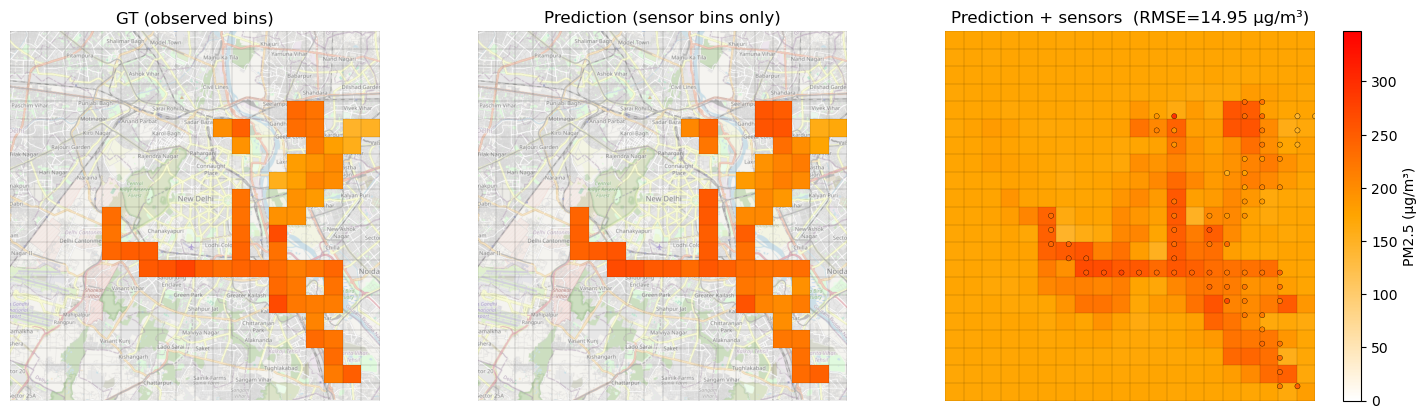

In [37]:
# ==============================
# Inline cartopy viz (no saving)
# ==============================
import numpy as np, torch, matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

cmap0 = LinearSegmentedColormap.from_list('', ['white', 'orange', 'red'])

def _draw_grid(ax, nlat=H, nlon=W, minlon=0, maxlon=1, minlat=0, maxlat=1):
    lat_lines = np.linspace(minlat, maxlat, nlat+1)
    lon_lines = np.linspace(minlon, maxlon, nlon+1)
    for y in lat_lines:
        ax.plot([minlon, maxlon], [y, y], c='black', lw=0.1, transform=ccrs.PlateCarree(), zorder=3)
    for x in lon_lines:
        ax.plot([x, x], [minlat, maxlat], c='black', lw=0.1, transform=ccrs.PlateCarree(), zorder=4)

def _safe_background(ax, path='./airdelhi_background.png'):
    try:
        back = plt.imread(path)
        ax.imshow(back, extent=[0,1,0,1], alpha=0.6, transform=ccrs.PlateCarree(), zorder=0)
    except Exception:
        pass

@torch.inference_mode()
def plot_pred_vs_sensors_inline(idx=None, vmax_std=3.0):
    """
    Displays inline (no saving):
      [0] GT (observed bins only)
      [1] Prediction (full) + sensor scatter (colored by GT sensor readings)
      [2] Prediction @ sensor bins only (masked to observed grid spots)
    """
    import numpy as np, torch, matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    from matplotlib import colors
    from matplotlib.colors import LinearSegmentedColormap

    cmap0 = LinearSegmentedColormap.from_list('', ['white', 'orange', 'red'])

    assert 'diff_inf' in globals(), "diff_inf not found"
    assert 'test_set' in globals(), "test_set (DelhiToGridCtx9) not found"

    ds_grid = test_set         # (x0, mask, cond, mean, std)
    ds_irreg = test_set.base   # (i, o, im, om)

    # choose an index with enough observations if none provided
    if idx is None:
        idx = 0
        for j in range(len(ds_grid)):
            x0j, mj, *_ = ds_grid[j][:3]
            if mj.sum().item() >= 30:
                idx = j
                break

    # fetch sample
    x0, m, cond, mu, std = ds_grid[idx]           # x0: (1,H,W) tanh(z), m:(1,H,W)
    i_pts, o_pts, im_pts, om_pts = ds_irreg[idx]  # irregular target scatter

    # predict
    xhat  = diff_inf.sample(cond.unsqueeze(0).to(DEVICE), clip=False).cpu()  # (1,1,H,W)
    mu_t  = torch.tensor(mu,  dtype=torch.float32).view(1,1,1,1)
    std_t = torch.tensor(std, dtype=torch.float32).view(1,1,1,1)

    raw_pred = inv_tanh_to_raw(xhat, mu_t, std_t).squeeze(0).squeeze(0).numpy()  # (H,W)
    raw_gt   = inv_tanh_to_raw(x0.unsqueeze(0), mu_t, std_t).squeeze(0).squeeze(0).numpy()
    mask     = m.squeeze(0).numpy().astype(bool)

    # irregular sensor values (raw) for scatter
    raw_pts = (o_pts * std + mu).numpy().squeeze(-1)
    lat_pts = om_pts[:, 0].numpy()
    lon_pts = om_pts[:, 1].numpy()

    # color scale in raw space
    vmax = float(mu + vmax_std * std)
    norm = colors.Normalize(vmin=0.0, vmax=max(1e-6, vmax))

    # RMSE on observed bins
    rmse_raw = float(np.sqrt(np.mean(((raw_pred - raw_gt)[mask])**2))) if mask.any() else float('nan')

    lon_edges = np.linspace(0, 1, W+1)
    lat_edges = np.linspace(0, 1, H+1)
    proj = ccrs.PlateCarree()

    fig, axes = plt.subplots(1, 3, figsize=(18, 4.8), subplot_kw=dict(projection=proj))

    # --- panel 0: GT (observed bins only)
    ax = axes[0]
    _safe_background(ax)
    gt_masked = raw_gt.copy()
    gt_masked[~mask] = np.nan
    pm0 = ax.pcolormesh(lon_edges, lat_edges, gt_masked, cmap=cmap0, norm=norm, transform=proj)
    _draw_grid(ax, nlat=H, nlon=W)
    ax.set_title("GT (observed bins)", fontsize=12)
    ax.set_extent([0,1,0,1], crs=proj)
    ax.set_axis_off()

    # --- panel 1: Prediction (full) + sensors


    # --- panel 2: Prediction @ sensor bins only (mask others)
    ax = axes[1]
    _safe_background(ax)
    pred_masked = raw_pred.copy()
    pred_masked[~mask] = np.nan
    pm2 = ax.pcolormesh(lon_edges, lat_edges, pred_masked, cmap=cmap0, norm=norm, transform=proj)
    _draw_grid(ax, nlat=H, nlon=W)
    ax.set_title("Prediction (sensor bins only)", fontsize=12)
    ax.set_extent([0,1,0,1], crs=proj)
    ax.set_axis_off()

    ax = axes[2]
    _safe_background(ax)
    pm1 = ax.pcolormesh(lon_edges, lat_edges, raw_pred, cmap=cmap0, norm=norm, transform=proj)
    if len(raw_pts) > 0:
        ax.scatter(lon_pts, lat_pts, c=raw_pts, s=14, lw=0.25, ec='k',
                   cmap=cmap0, norm=norm, transform=proj, zorder=5)
    _draw_grid(ax, nlat=H, nlon=W)
    ax.set_title(f"Prediction + sensors  (RMSE={rmse_raw:.2f} µg/m³)", fontsize=12)
    ax.set_extent([0,1,0,1], crs=proj)
    ax.set_axis_off()

    # one shared colorbar
    cbar = fig.colorbar(pm2, ax=axes.ravel().tolist(), fraction=0.03, pad=0.02)
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label("PM2.5 (µg/m³)", fontsize=10)

    # plt.tight_layout()
    plt.show()

# run inline




plot_pred_vs_sensors_inline(idx=3, vmax_std=2)



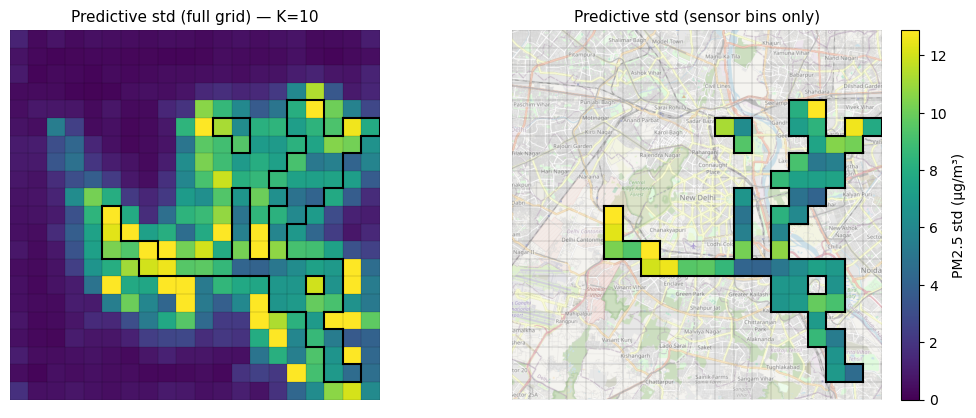

[UQ] idx=3 | RMSE(mean on obs)=9.545 µg/m³ | K=10 | vmax(std)=12.888 µg/m³


In [41]:
# ==============================
# UQ maps (per-sample, K draws), inline
# ==============================
import numpy as np, torch, matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors


def _draw_mask_outline(ax, mask: np.ndarray, lon_edges: np.ndarray, lat_edges: np.ndarray,
                       lw: float = 1.5, transform=ccrs.PlateCarree()):
    """
    Draws an outline that exactly follows grid-cell boundaries where mask==1.
    No interior lines between adjacent True cells.
    """
    H, W = mask.shape
    m = mask.astype(bool)
    for i in range(H):
        y0, y1 = lat_edges[i], lat_edges[i+1]
        for j in range(W):
            if not m[i, j]:
                continue
            x0, x1 = lon_edges[j], lon_edges[j+1]
            # left edge
            if j == 0 or not m[i, j-1]:
                ax.plot([x0, x0], [y0, y1], color='k', lw=lw, transform=transform, zorder=6,
                        solid_joinstyle='miter')
            # right edge
            if j == W-1 or not m[i, j+1]:
                ax.plot([x1, x1], [y0, y1], color='k', lw=lw, transform=transform, zorder=6,
                        solid_joinstyle='miter')
            # bottom edge
            if i == 0 or not m[i-1, j]:
                ax.plot([x0, x1], [y0, y0], color='k', lw=lw, transform=transform, zorder=6,
                        solid_joinstyle='miter')
            # top edge
            if i == H-1 or not m[i+1, j]:
                ax.plot([x0, x1], [y1, y1], color='k', lw=lw, transform=transform, zorder=6,
                        solid_joinstyle='miter')



@torch.inference_mode()
def plot_uq_maps_inline(idx: int, K: int = 10, std_vmax_pct: float = 95.0, outline_lw: float = 1.5):
    import numpy as np, torch, matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    from matplotlib import colors

    x0, m, cond, mu, std = test_set[idx]
    mu_t  = torch.tensor(mu,  dtype=torch.float32).view(1,1,1,1)
    std_t = torch.tensor(std, dtype=torch.float32).view(1,1,1,1)
    mask  = m.squeeze(0).numpy().astype(bool)

    S = []
    for _ in range(K):
        S.append(diff_inf.sample(cond.unsqueeze(0).to(DEVICE), clip=False).cpu())
    S = torch.cat(S, dim=0)  # (K,1,H,W)

    z_smp   = torch.atanh(S.clamp(-0.999, 0.999))
    raw_smp = z_smp * std_t + mu_t
    raw_mean = raw_smp.mean(dim=0).squeeze(0).numpy()
    raw_std  = raw_smp.std(dim=0, unbiased=False).squeeze(0).numpy()

    z_gt   = torch.atanh(x0.unsqueeze(0).clamp(-0.999, 0.999))
    raw_gt = (z_gt * std_t + mu_t).squeeze(0).squeeze(0).numpy()
    rmse_mean_on_obs = float(np.sqrt(np.mean((raw_mean[mask] - raw_gt[mask])**2))) if mask.any() else float('nan')

    vmax_std = float(np.nanpercentile(raw_std, std_vmax_pct))
    vmax_std = max(vmax_std, 1e-6)
    norm_std = colors.Normalize(vmin=0.0, vmax=vmax_std)

    raw_std_masked = raw_std.copy()
    raw_std_masked[~mask] = np.nan

    lon_edges = np.linspace(0, 1, W+1)
    lat_edges = np.linspace(0, 1, H+1)
    proj = ccrs.PlateCarree()

    fig, axes = plt.subplots(1, 2, figsize=(12.5, 4.8), subplot_kw=dict(projection=proj))

    # Full-grid std + exact outline
    ax = axes[0]
    try: _safe_background(ax)
    except NameError: pass
    im0 = ax.pcolormesh(lon_edges, lat_edges, raw_std, cmap='viridis', norm=norm_std, transform=proj)
    _draw_mask_outline(ax, mask, lon_edges, lat_edges, lw=outline_lw, transform=proj)
    try: _draw_grid(ax, nlat=H, nlon=W)
    except NameError: pass
    ax.set_title(f"Predictive std (full grid) — K={K}", fontsize=11)
    ax.set_extent([0,1,0,1], crs=proj); ax.set_axis_off()

    # Sensor-only std + exact outline
    ax = axes[1]
    try: _safe_background(ax)
    except NameError: pass
    im1 = ax.pcolormesh(lon_edges, lat_edges, raw_std_masked, cmap='viridis', norm=norm_std, transform=proj)
    _draw_mask_outline(ax, mask, lon_edges, lat_edges, lw=outline_lw, transform=proj)
    try: _draw_grid(ax, nlat=H, nlon=W)
    except NameError: pass
    ax.set_title("Predictive std (sensor bins only)", fontsize=11)
    ax.set_extent([0,1,0,1], crs=proj); ax.set_axis_off()

    cbar = fig.colorbar(im1, ax=axes.ravel().tolist(), fraction=0.03, pad=0.02)
    cbar.ax.tick_params(labelsize=10); cbar.set_label("PM2.5 std (µg/m³)", fontsize=10)

    # plt.tight_layout(); 
    plt.show()

    print(f"[UQ] idx={idx} | RMSE(mean on obs)={rmse_mean_on_obs:.3f} µg/m³ | K={K} | vmax(std)={vmax_std:.3f} µg/m³")

    return dict(raw_mean=raw_mean, raw_std=raw_std, raw_std_masked=raw_std_masked,
                rmse_mean_on_obs=rmse_mean_on_obs, vmax_std=vmax_std)



# --- run for your chosen sample (idx=3) with 10 draws ---
uq = plot_uq_maps_inline(idx=3, K=10, std_vmax_pct=95.0)


In [43]:
# ===========================
# Multi-step rollout (sensor-only feedback)
# ===========================
import numpy as np, torch

@torch.inference_mode()
def rollout_unroll_at_sensors(idx: int, steps: int = 6, K: int = 1, clip: bool = False, verbose: bool = True):
    """
    Unroll 'steps' ahead starting from sample 'idx'.
    At each step:
      - sample K forecasts from diff_inf with current cond
      - compute mean/std in RAW µg/m³ vs GT at that step (masked)
      - build next-step cond by shifting window and appending a grid/mask that
        contains ONLY predicted values at that step's sensor bins (from om)

    Returns: list of dicts, one per step, with RMSE and optional arrays.
    """
    assert 'diff_inf' in globals() and 'test_set' in globals()
    ds_grid = test_set          # (x0, m, cond, mean, std)
    ds_base = test_set.base     # (i, o, im, om) + .day_record

    H_, W_ = H, W
    results = []

    # start context
    x0_0, m_0, cond_cur, mu_all, std_all = ds_grid[idx]
    mu_t  = torch.tensor(mu_all,  dtype=torch.float32).view(1,1,1,1)
    std_t = torch.tensor(std_all, dtype=torch.float32).view(1,1,1,1)

    for s in range(steps):
        # safety: range/continuity
        if idx + s >= len(ds_grid):
            if verbose: print(f"[rollout] stop at s={s}: out of range")
            break

        # ---- sample K draws at current step (t+s+1) ----
        samples = []
        for _ in range(K):
            xhat = diff_inf.sample(cond_cur.unsqueeze(0).to(DEVICE), clip=clip).cpu()   # (1,1,H,W) in tanh(z)
            samples.append(xhat.squeeze(0))  # (1,H,W)
        S_tanh = torch.stack(samples, 0)     # (K,1,H,W)

        # mean/std in RAW space for evaluation
        z_smp   = torch.atanh(S_tanh.clamp(-0.999, 0.999))        # (K,1,H,W)
        raw_smp = z_smp * std_t + mu_t                             # (K,1,H,W)
        raw_mean = raw_smp.mean(dim=0).squeeze(0).numpy()          # (H,W)
        raw_std  = raw_smp.std(dim=0, unbiased=False).squeeze(0).numpy()

        # GT for this step
        x0_t, m_t, _, mu_tgt, std_tgt = ds_grid[idx + s]
        mask_np = m_t.squeeze(0).numpy().astype(bool)
        raw_gt  = inv_tanh_to_raw(x0_t.unsqueeze(0),
                                  torch.tensor(mu_tgt).view(1,1,1,1),
                                  torch.tensor(std_tgt).view(1,1,1,1)).squeeze(0).squeeze(0).numpy()
        rmse = float(np.sqrt(np.mean(((raw_mean - raw_gt)[mask_np])**2))) if mask_np.any() else float('nan')

        results.append(dict(step=s+1, rmse_raw=rmse, n_obs=int(mask_np.sum()),
                            raw_mean=raw_mean, raw_std=raw_std, raw_gt=raw_gt, mask=mask_np))

        # ---- build next-step cond by appending sensor-only predicted grid ----
        if s < steps - 1:
            # sensor positions at THIS step (t+s+1) become the newest past for the NEXT step
            _, _, _, om = ds_base[idx + s]           # (No,3) with [lat, lon, t_rel]
            lat_idx = (om[:, 0] * (H_-1)).round().long().clamp(0, H_-1)
            lon_idx = (om[:, 1] * (W_-1)).round().long().clamp(0, W_-1)

            # predicted newest past grid/mask in tanh(z) space
            xhat_mean_tanh = S_tanh.mean(0).squeeze(0)            # (H,W)
            grid_new = torch.zeros(H_, W_)
            mask_new = torch.zeros(H_, W_)
            grid_new[lat_idx, lon_idx] = xhat_mean_tanh[lat_idx, lon_idx]
            mask_new[lat_idx, lon_idx] = 1.0

            # shift the 9-step window and append new
            past_grids = cond_cur[2:11].clone()                   # (9,H,W)
            past_masks = cond_cur[11:20].clone()                  # (9,H,W)
            past_grids = torch.cat([past_grids[1:], grid_new.unsqueeze(0)], dim=0)
            past_masks = torch.cat([past_masks[1:], mask_new.unsqueeze(0)], dim=0)
            cond_cur   = torch.cat([cond_cur[:2], past_grids, past_masks], dim=0)

    if verbose:
        for r in results:
            print(f"step {r['step']:>2d}: RMSE_raw={r['rmse_raw']:.3f} µg/m³ (n_obs={r['n_obs']})")

    return results



# e.g., start from the sample you liked (idx=3), unroll 6 steps, with a small ensemble for UQ
roll = rollout_unroll_at_sensors(idx=3, steps=6, K=10, clip=False)



step  1: RMSE_raw=9.696 µg/m³ (n_obs=58)
step  2: RMSE_raw=12.463 µg/m³ (n_obs=38)
step  3: RMSE_raw=17.391 µg/m³ (n_obs=52)
step  4: RMSE_raw=28.515 µg/m³ (n_obs=34)
step  5: RMSE_raw=38.210 µg/m³ (n_obs=59)
step  6: RMSE_raw=39.584 µg/m³ (n_obs=34)


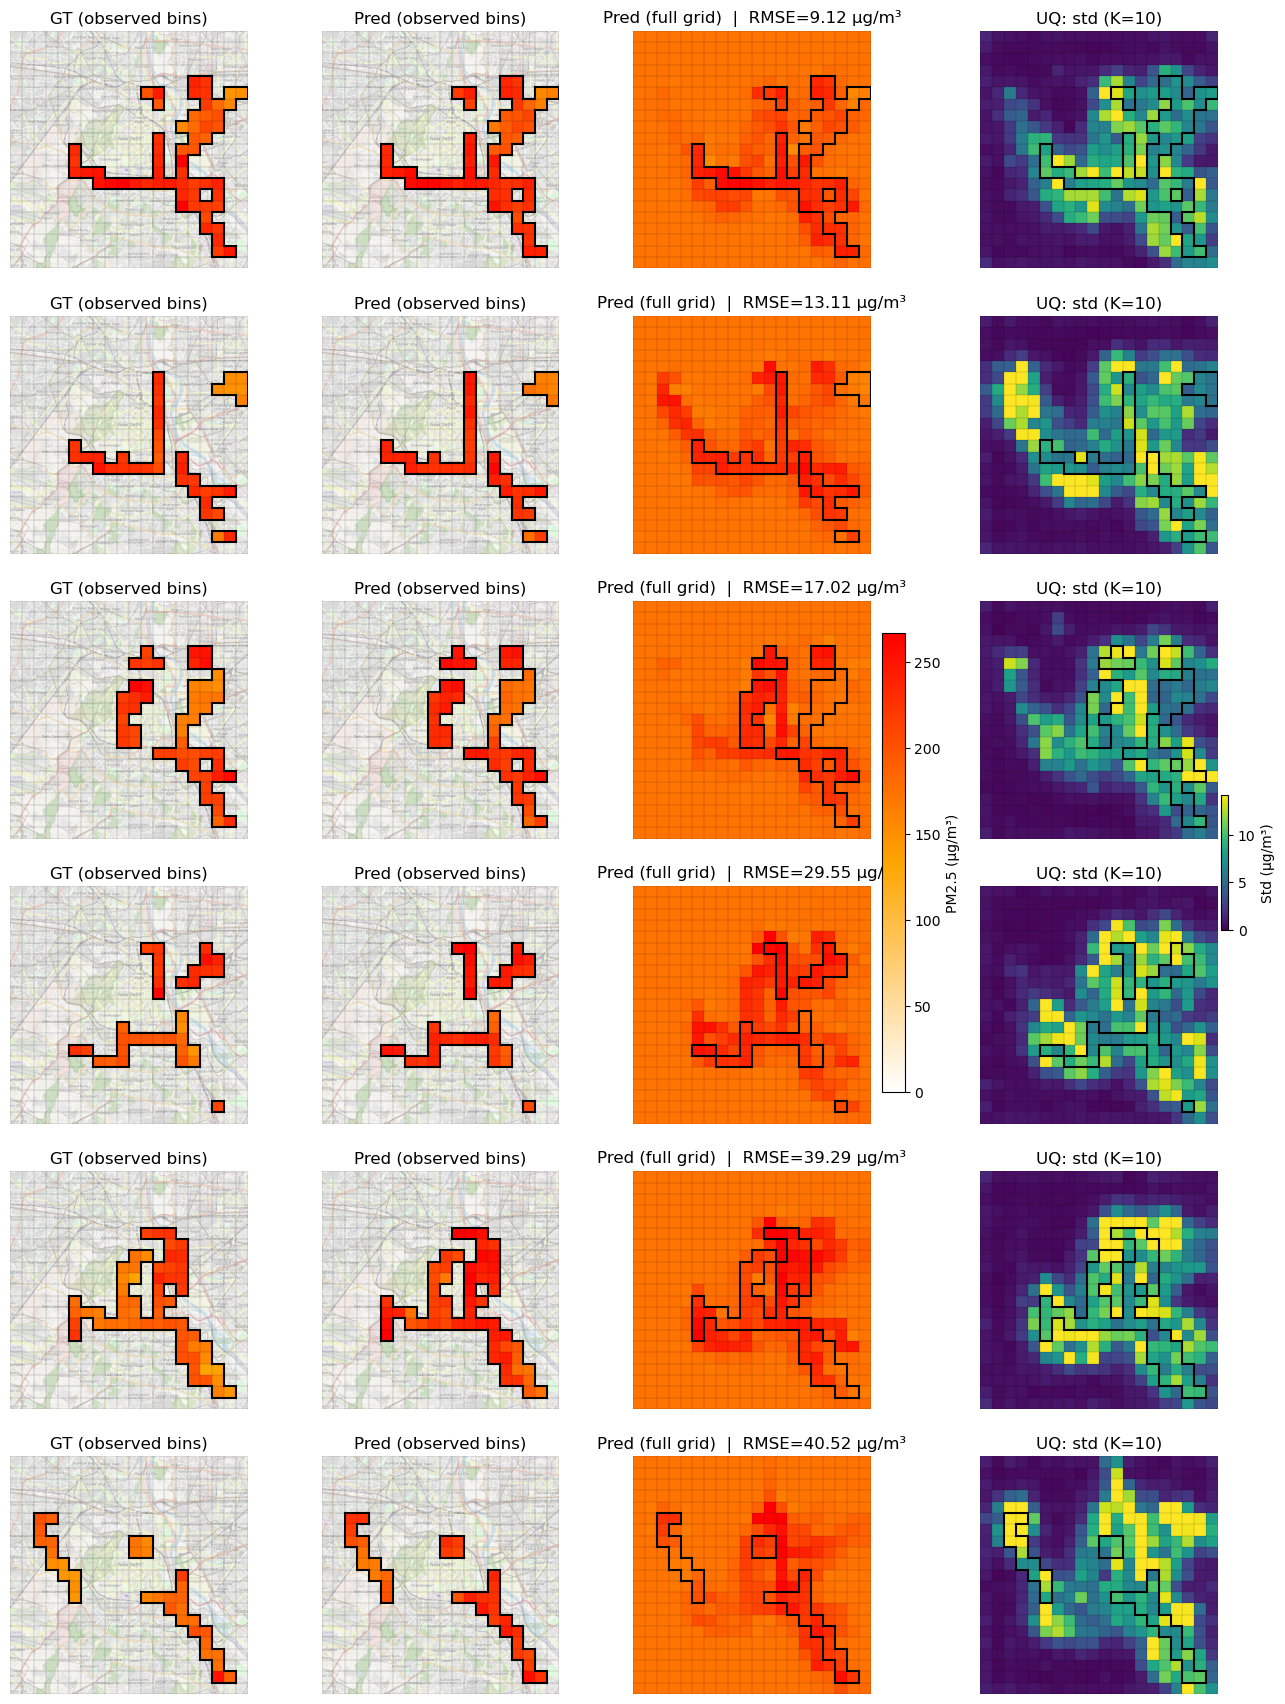

In [45]:
# ===========================
# Multi-step rollout (sensor-only feedback) + row-wise viz
# ===========================
import numpy as np, torch, matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as mplcm  # <-- NEW

proj = ccrs.PlateCarree()
cmap_val = LinearSegmentedColormap.from_list('', ['white', 'orange', 'red'])  # PM2.5
cmap_std = 'viridis'                                                          # UQ

def _safe_background(ax, path='./airdelhi_background.png'):
    try:
        back = plt.imread(path)
        ax.imshow(back, extent=[0,1,0,1], alpha=0.6, transform=proj, zorder=0)
    except Exception:
        pass

def _draw_grid(ax, nlat=H, nlon=W, minlon=0, maxlon=1, minlat=0, maxlat=1):
    lat_lines = np.linspace(minlat, maxlat, nlat+1)
    lon_lines = np.linspace(minlon, maxlon, nlon+1)
    for y in lat_lines:
        ax.plot([minlon, maxlon], [y, y], c='k', lw=0.1, transform=proj, zorder=3)
    for x in lon_lines:
        ax.plot([x, x], [minlat, maxlat], c='k', lw=0.1, transform=proj, zorder=3)

def _draw_mask_outline(ax, mask: np.ndarray, lon_edges: np.ndarray, lat_edges: np.ndarray,
                       lw: float = 1.5):
    """Draw borders exactly along cell edges for mask==1; no interior lines."""
    Hm, Wm = mask.shape
    m = mask.astype(bool)
    for i in range(Hm):
        y0, y1 = lat_edges[i], lat_edges[i+1]
        for j in range(Wm):
            if not m[i, j]:
                continue
            x0, x1 = lon_edges[j], lon_edges[j+1]
            # left
            if j == 0 or not m[i, j-1]:
                ax.plot([x0, x0], [y0, y1], color='k', lw=lw, transform=proj, zorder=6)
            # right
            if j == Wm-1 or not m[i, j+1]:
                ax.plot([x1, x1], [y0, y1], color='k', lw=lw, transform=proj, zorder=6)
            # bottom
            if i == 0 or not m[i-1, j]:
                ax.plot([x0, x1], [y0, y0], color='k', lw=lw, transform=proj, zorder=6)
            # top
            if i == Hm-1 or not m[i+1, j]:
                ax.plot([x0, x1], [y1, y1], color='k', lw=lw, transform=proj, zorder=6)

@torch.inference_mode()
def rollout_unroll_at_sensors(idx: int, steps: int = 6, K: int = 10, clip: bool = False, verbose: bool = True):
    assert 'diff_inf' in globals() and 'test_set' in globals()
    ds_grid = test_set        # (x0, m, cond, mean, std)
    ds_base = test_set.base   # (i, o, im, om)

    H_, W_ = H, W
    results = []

    # start context
    x0_0, m_0, cond_cur, mu_all, std_all = ds_grid[idx]
    mu_t  = torch.tensor(mu_all,  dtype=torch.float32).view(1,1,1,1)
    std_t = torch.tensor(std_all, dtype=torch.float32).view(1,1,1,1)

    for s in range(steps):
        if idx + s >= len(ds_grid):
            if verbose: print(f"[rollout] stop at s={s}: out of range")
            break

        # K draws for current horizon
        samples = []
        for _ in range(K):
            xhat = diff_inf.sample(cond_cur.unsqueeze(0).to(DEVICE), clip=clip).cpu()  # (1,1,H,W) tanh(z)
            samples.append(xhat.squeeze(0))  # (1,H,W)
        S_tanh = torch.stack(samples, 0)     # (K,1,H,W)

        # mean/std in RAW space
        z_smp   = torch.atanh(S_tanh.clamp(-0.999, 0.999))
        raw_smp = z_smp * std_t + mu_t
        raw_mean = raw_smp.mean(dim=0).squeeze(0).numpy()   # (H,W)
        raw_std  = raw_smp.std(dim=0, unbiased=False).squeeze(0).numpy()

        # GT + mask for this horizon
        x0_t, m_t, _, mu_tgt, std_tgt = ds_grid[idx + s]
        mask_np = m_t.squeeze(0).numpy().astype(bool)
        raw_gt  = (torch.atanh(x0_t.unsqueeze(0).clamp(-0.999, 0.999)) * 
                   torch.tensor(std_tgt).view(1,1,1,1) + 
                   torch.tensor(mu_tgt).view(1,1,1,1)).squeeze(0).squeeze(0).numpy()

        # RMSE on observed bins
        rmse = float(np.sqrt(np.mean(((raw_mean - raw_gt)[mask_np])**2))) if mask_np.any() else float('nan')

        results.append(dict(step=s+1, rmse_raw=rmse, n_obs=int(mask_np.sum()),
                            raw_mean=raw_mean, raw_std=raw_std, raw_gt=raw_gt, mask=mask_np))

        # build next-step cond by appending sensor-only predicted grid
        if s < steps - 1:
            _, _, _, om = ds_base[idx + s]           # (No,3) [lat, lon, t_rel]
            lat_idx = (om[:, 0] * (H_-1)).round().long().clamp(0, H_-1)
            lon_idx = (om[:, 1] * (W_-1)).round().long().clamp(0, W_-1)

            xhat_mean_tanh = S_tanh.mean(0).squeeze(0)  # (H,W) tanh(z)
            grid_new = torch.zeros(H_, W_); mask_new = torch.zeros(H_, W_)
            grid_new[lat_idx, lon_idx] = xhat_mean_tanh[lat_idx, lon_idx]
            mask_new[lat_idx, lon_idx] = 1.0

            # shift past 9 and append
            past_grids = cond_cur[2:11].clone()
            past_masks = cond_cur[11:20].clone()
            past_grids = torch.cat([past_grids[1:], grid_new.unsqueeze(0)], dim=0)
            past_masks = torch.cat([past_masks[1:], mask_new.unsqueeze(0)], dim=0)
            cond_cur   = torch.cat([cond_cur[:2], past_grids, past_masks], dim=0)

    if verbose:
        for r in results:
            print(f"t+{r['step']:>2d}: RMSE_raw={r['rmse_raw']:.3f} µg/m³ (n_obs={r['n_obs']})")
    return results

@torch.inference_mode()
def plot_rollout_rows(idx: int, steps: int = 6, K: int = 10, clip: bool = False,
                      raw_vmax_pct: float = 99.0, std_vmax_pct: float = 95.0,
                      outline_lw: float = 1.5):
    """Rows = horizons; Cols = [GT@obs, Pred@obs, Pred(full), UQ std (outlined)]."""
    roll = rollout_unroll_at_sensors(idx=idx, steps=steps, K=K, clip=clip, verbose=False)
    if len(roll) == 0:
        print("No steps to plot."); 
        return roll

    # global edges & norms
    lon_edges = np.linspace(0, 1, W+1); lat_edges = np.linspace(0, 1, H+1)

    # RAW scale based on all GT+Pred over observed bins across horizons
    vals_raw = []
    for r in roll:
        m = r['mask']
        vals_raw.append(r['raw_gt'][m])
        vals_raw.append(r['raw_mean'][m])
    vals_raw = np.concatenate(vals_raw) if len(vals_raw) else np.array([0.0])
    raw_vmax = float(np.nanpercentile(vals_raw, raw_vmax_pct))
    raw_norm = colors.Normalize(vmin=0.0, vmax=max(raw_vmax, 1e-6))

    # STD scale based on all std values across horizons
    vals_std = np.concatenate([r['raw_std'].ravel() for r in roll])
    std_vmax = float(np.nanpercentile(vals_std, std_vmax_pct))
    std_norm = colors.Normalize(vmin=0.0, vmax=max(std_vmax, 1e-6))

    # figure
    R = len(roll)
    fig, axes = plt.subplots(R, 4, figsize=(16, 3.6*R), subplot_kw=dict(projection=proj))
    if R == 1:
        axes = axes[None, :]  # ensure 2D indexing

    # mappables for shared colorbars (version-safe)
    mappable_raw = mplcm.ScalarMappable(norm=raw_norm, cmap=cmap_val); mappable_raw.set_array([])
    mappable_std = mplcm.ScalarMappable(norm=std_norm,
                                        cmap=plt.get_cmap(cmap_std) if isinstance(cmap_std, str) else cmap_std)
    mappable_std.set_array([])

    for r, row_axes in zip(roll, axes):
        gt, pred, std_map, mask = r['raw_gt'], r['raw_mean'], r['raw_std'], r['mask']
        gt_masked   = gt.copy();   gt_masked[~mask]   = np.nan
        pred_masked = pred.copy(); pred_masked[~mask] = np.nan

        # Col 0: GT at observed bins
        ax = row_axes[0]
        _safe_background(ax); 
        ax.pcolormesh(lon_edges, lat_edges, gt_masked, cmap=cmap_val, norm=raw_norm, transform=proj)
        _draw_mask_outline(ax, mask, lon_edges, lat_edges, lw=outline_lw)
        _draw_grid(ax); ax.set_axis_off()
        ax.set_title("GT (observed bins)")

        # Col 1: Pred at observed bins
        ax = row_axes[1]
        _safe_background(ax)
        ax.pcolormesh(lon_edges, lat_edges, pred_masked, cmap=cmap_val, norm=raw_norm, transform=proj)
        _draw_mask_outline(ax, mask, lon_edges, lat_edges, lw=outline_lw)
        _draw_grid(ax); ax.set_axis_off()
        ax.set_title("Pred (observed bins)")

        # Col 2: Pred full grid
        ax = row_axes[2]
        _safe_background(ax)
        ax.pcolormesh(lon_edges, lat_edges, pred, cmap=cmap_val, norm=raw_norm, transform=proj)
        _draw_mask_outline(ax, mask, lon_edges, lat_edges, lw=outline_lw)
        _draw_grid(ax); ax.set_axis_off()
        ax.set_title(f"Pred (full grid)  |  RMSE={r['rmse_raw']:.2f} µg/m³")

        # Col 3: UQ std (outlined)
        ax = row_axes[3]
        _safe_background(ax)
        ax.pcolormesh(lon_edges, lat_edges, std_map, cmap=cmap_std, norm=std_norm, transform=proj)
        _draw_mask_outline(ax, mask, lon_edges, lat_edges, lw=outline_lw)
        _draw_grid(ax); ax.set_axis_off()
        ax.set_title(f"UQ: std (K={K})")

    # shared colorbars (set labels explicitly for compatibility)
    cbar_raw = fig.colorbar(mappable_raw, ax=axes[:, :3].ravel().tolist(), fraction=0.025, pad=0.012)
    cbar_raw.set_label("PM2.5 (µg/m³)")
    cbar_std = fig.colorbar(mappable_std, ax=axes[:, 3].ravel().tolist(),   fraction=0.025, pad=0.012)
    cbar_std.set_label("Std (µg/m³)")

    # plt.tight_layout()
    plt.show()

    return roll

# ----------------- run it -----------------
_ = plot_rollout_rows(idx=3, steps=6, K=10, clip=False,
                      raw_vmax_pct=99.0, std_vmax_pct=95.0, outline_lw=1.5)
